# Usage of Roadside Prediction Model

# Load Libraries

In [94]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import scipy.stats as stats 

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# to make this notebook's output identical at every run
np.random.seed(42)

# Function Definitions

In [181]:
def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', index_col=False, header='infer', float_precision=2 )
    return df

def draw_col_shape(df_feature,cols):
    # draw a bar graph with he number of members of a columns specify in field Cols
    
    # Dictionary for X Axis Labels
    dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
                 'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
                 'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
                 'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
                 'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
                 'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
                 'tenure':'Tenure Range', 'generation':'Generation', 'total_calls':'Total Breakdown Calls', 'aaa_mortgage':'Used Mortgage Service',
                  'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service','aaa_travel':'Travel Services',
                 'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
                 'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle','total_member_cost':'Total Member Avg. Costs',
                 'no_members':'Total Members with Household', 'aaa_id_theft':'ID Theft Service', 'use_road_side':'Use Roadside'
                }


    # number of members per state

    for col in cols:
        counts = df_feature[col].value_counts()
        sns.set(style="whitegrid")
        plt.axhline(0, color="k", clip_on=False)
        plt.ylabel("# of Classes",fontsize=14, fontweight='bold')
        plt.xlabel("Classes", fontsize=14, fontweight='bold')
        plt.title('Total  Number of Classes',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        sns.barplot(counts.index, counts.values)
        plt.xticks(
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='large')
        i = 0
        for v in list(counts.values):
            plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
            i +=1
        plt.show()
        counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
        counts.reset_index(inplace=True)
        counts.rename(columns={"index": dict_cols[col], col: "# of Classes"}, inplace=True)
        fig = ff.create_table(counts, height_constant=30, index=False)
        py.iplot(fig)
        return

def cross_entropy(predictions, targets, epsilon=1e-10):
    # To calculate the cross Entropy Loss to validate model performance
    # Cross Entropy Loss
        # Cross-entropy loss, or log loss, measures the performance of a classification model 
        # whose output is a probability value between 0 and 1. #
        # Cross-entropy loss increases as the predicted probability diverges from the actual label. 
        # So predicting a probability of .012 when the actual observation label is 1 would be bad and 
        # result in a high loss value. # A perfect model would have a log loss of 0.
        
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
    return ce_loss

def road_side_usage(calls):
    if calls > 0: return 1
    elif calls == 0: return 0
    else: return np.nan


# Load data from consolidate file by household key and transacton file 

In [96]:
# Load data from the View create using Capstone AAA - EDA .ipynb
df_household = read_data('household_view.csv')
df_transaction = read_data('capstone_aaa_featured.csv')
df_original_house_hold = df_household.copy()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
var_to_predict = ['use_road_side']
var_to_predict_title = 'Roadside Services'
var_to_predict_save = 'rds'
test_size = 0.5
# Create roadside usage
df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))

In [97]:
df_household.head()

,membership_id,household_key,income,member_status,state_grouped,credit_ranges,cancel_reason,renew_method,plus_indicator_description,zip,sc_vehicle_manufacturer_name,sc_vehicle_model_name,race,home_owner,education,dwelling_type,gender,occupation_code,occupation_group,occupant_type,mosaic_household,mosaic_global_household,kcl_b_ind_mosaicsgrouping,generation,tenure,aaa_no_tenure,aaa_member_tenure_years,aaa_mean_age,length_of_residence,aaa_mortgage,aaa_credit_card,aaa_deposit,aaa_home_equity,aaa_financial_service,aaa_auto_insurance,aaa_id_theft,aaa_motorcycle_indicator,aaa_travel,aaa_mean_child,aaa_mean_total_cost,aaa_no_race,aaa_no_home_owner,aaa_no_education,aaa_no_income,aaa_no_dwelling_type,aaa_no_credit_ranges,aaa_no_gender,aaa_no_language,aaa_no_reason_joined,aaa_cancel_reason,aaa_no_mosaic_household,aaa_no_mosaic_global_household,aaa_no_kcl_b_ind_mosaicsgrouping,aaa_no_occupation_code,aaa_no_occupation_group,aaa_no_occupant_type,aaa_no_plus_indicator_description,aaa_no_generation,total_calls_year_1,total_calls_year_2,total_calls_year_3,total_member_cost_1,total_member_cost_2,total_member_cost_3,basic_cost,plus_cost,premier_cost,mean_basic_cost,mean_plus_cost,mean_premier_cost,total_calls,total_member_cost,mean_total_member_cost,vehicle,total_cost,mean_total_cost,total_members_in_household,total_calls_veh,total_cost_veh,total_member_cost_veh,mean_total_calls_veh,mean_total_cost_veh,mean_total_member_cost_veh,consumer_score,use_road_side
0,153,4500791,"30-39,999",ACTIVE,RI,600-649,UNKNOWN,AUTO RENEW,BASIC MEMBERSHIP,2893,TOYOTA,CAMRY,CAUCASION / WHITE - ENGLISH,HOME OWNER,SOME COLLEGE,SMALL OR LARGE MULTI-FAMILY W/APT NUMBER,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SENIOR DISCOUNTS,LOW INCOME ELDERS,GOLDEN YEAR GUARDIANS,POST-WAR (< 1948),+40 YEARS,0,49,97.0000,15.0000,0,1,0,0,0,0,0,0.0000,0,2.0000,33.8333,2.0000,0.0000,1.0000,8.0000,2.0000,5.0000,nan,0.0000,nan,nan,11.0000,7.0000,3.0000,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,18.0000,0.0000,0.0000,585.0000,304.5000,0.0000,0.0000,33.8333,0.0000,0.0000,18.0000,585.0000,65.0000,TOYOTA CAMRY,304.5000,33.8333,1,5836.0000,107732.6600,303128.5500,2.5485,47.0448,132.3705,73.0000,1
1,155,4317516,UNKNOWN,CANCELLED,RI,UNKNOWN,DECEASED,NOTICE,UNKNOWN,2878,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SFDU,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,AGING IN PLACE,COMFORTABLE RETIREMENT,AUTUMN YEARS,UNKNOWN,BETWEEN 11 & 15 YEARS,1,13,nan,0.0000,0,0,0,0,0,0,0,nan,0,nan,0.0000,nan,nan,nan,nan,0.0000,nan,nan,nan,nan,2.0000,1.0000,1.0000,1.0000,nan,nan,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,UNKNOWN UNKNOWN,0.0000,0.0000,1,1211.0000,53.0000,62130.2300,0.1645,0.0072,8.4416,nan,0
2,163,11622991,"50-59,999",ACTIVE,RI,750-799,UNKNOWN,AUTO RENEW,BASIC MEMBERSHIP,2889,HYUNDAI,TUCSON,CAUCASION / WHITE - EUROPEAN,HOME OWNER,HIGH SCHOOL,SFDU,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,NO PLACE LIKE HOME,ROUTINE SERVICE WORKERS,THRIVING BOOMERS,BABY BOOMERS (1948 - 1968),BETWEEN 1 & 5 YEARS,6,59,47.6667,8.5556,0,0,0,0,0,0,0,1.0000,0,1.0000,39.2056,6.0000,0.0000,2.0000,4.0000,0.0000,1.0000,nan,0.0000,nan,1.0000,3.0000,3.0000,4.0000,nan,nan,nan,2.0000,3.0000,3.0000,6.0000,0.0000,176.5500,353.1000,0.0000,352.8500,0.0000,0.0000,39.2056,0.0000,0.0000,9.0000,529.6500,58.8500,HYUNDAI TUCSON,352.8500,39.2056,4,1548.0000,28668.8300,79687.0900,2.4416,45.2190,125.6894,73.0000,1
3,182,579810,"50-59,999",ACTIVE,RI,650-699,UNKNOWN,NOTICE,BASIC MEMBERSHIP,2863,INFINITI,QX56,CAUCASION / WHITE - EUROPEAN,HOME OWNER,SOME COLLEGE,SFDU,MALE,RETIRED,RETIRED - KNOWN,UNKNOWN,TOWN ELDERS,COMFORTABLE RETIREMENT,GOLDEN YEAR GUARDIANS,POST-WAR (< 1948),+40 YEARS,0,59,83.0000,15.0000,0,0,0,0,0,1,0,0.0000,0,1.0000,28.0000,1.0000,0.0000,1.0000,4.0000,0.0000,3.0000,2.0000,0.0000,nan,nan,6.0000,1.0000,3.0000,1.0000,3.0000,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,28.0000,0.0000,0.0000,28.0000,0.0000,0.0000,0.0000,0.0000,0.0000,INFINITI QX56,28.0000,28.0000,1,337.0000,4289.6000

# Cars that are most likely to break down 
https://247wallst.com/special-report/2019/12/12/these-new-cars-are-most-likely-to-break-down/2/

# Top Car 35 Car brand according to consumer reports
https://www.autonews.com/retail/subaru-reaches-top-consumer-reports-rankings-tesla-falters


In [98]:
df_group_veh_manuf = df_transaction.groupby(by='sc_vehicle_manufacturer_name').agg(({'total_calls':sum, 
                                                                                     'total_cost' :['sum','mean']
                                                                                    }))

In [99]:
df_transaction.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21343 entries, 0 to 21342
Data columns (total 166 columns):
individual_key                    int64
household_key                     int64
member_flag                       int64
city                              object
state_grouped                     object
zip5                              int64
zip9                              int64
fsv_cmsi_flag                     int64
fsv_credit_card_flag              int64
fsv_deposit_program_flag          int64
fsv_home_equity_flag              int64
fsv_id_theft_flag                 int64
fsv_mortgage_flag                 int64
ins_client_flag                   int64
trv_globalware_flag               int64
number_of_children                object
responded_to_catalog              object
race                              object
length_of_residence               int64
mail_responder                    object
home_owner                        object
income                            object
da

In [100]:
df_household.groupby(by=var_to_predict).mean()

,membership_id,household_key,zip,aaa_no_tenure,aaa_member_tenure_years,aaa_mean_age,length_of_residence,aaa_mortgage,aaa_credit_card,aaa_deposit,aaa_home_equity,aaa_financial_service,aaa_auto_insurance,aaa_id_theft,aaa_motorcycle_indicator,aaa_travel,aaa_mean_child,aaa_mean_total_cost,aaa_no_race,aaa_no_home_owner,aaa_no_education,aaa_no_income,aaa_no_dwelling_type,aaa_no_credit_ranges,aaa_no_gender,aaa_no_language,aaa_no_reason_joined,aaa_cancel_reason,aaa_no_mosaic_household,aaa_no_mosaic_global_household,aaa_no_kcl_b_ind_mosaicsgrouping,aaa_no_occupation_code,aaa_no_occupation_group,aaa_no_occupant_type,aaa_no_plus_indicator_description,aaa_no_generation,total_calls_year_1,total_calls_year_2,total_calls_year_3,total_member_cost_1,total_member_cost_2,total_member_cost_3,basic_cost,plus_cost,premier_cost,mean_basic_cost,mean_plus_cost,mean_premier_cost,total_calls,total_member_cost,mean_total_member_cost,total_cost,mean_total_cost,total_members_in_household,total_calls_veh,total_cost_veh,total_member_cost_veh,mean_total_calls_veh,mean_total_cost_veh,mean_total_member_cost_veh,consumer_score
use_road_side,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,136847.5000,14028509.6472,3212.9717,1.0884,46.7762,78.8445,4.6585,0.0369,0.0830,0.0059,0.0005,0.0369,0.2151,0.0292,0.3049,0.0975,1.6298,9.4832,2.6903,0.0955,1.9233,5.1201,0.4400,2.5084,1.5288,0.1403,3.1346,3.5438,11.1422,3.2345,5.1179,7.1631,5.3558,1.3049,0.8991,0.6178,0.0000,0.0000,0.0000,0.0000,0.0000,0.6527,25.3556,1.8195,0.0369,8.8164,0.5554,0.0123,0.0000,0.6527,0.0641,27.5811,9.4832,1.9111,1602.9353,11982.5783,83273.5786,0.7596,10.8266,40.0927,68.1360
1,117763.9182,15419978.1412,2999.4848,1.4147,46.6586,72.0183,6.9451,0.0936,0.1298,0.0049,0.0016,0.0936,0.3172,0.0558,0.6133,0.1689,1.7586,31.8475,2.8299,0.1177,1.9947,5.0769,0.3867,2.5250,1.6233,0.2011,2.5357,4.2846,10.4872,3.0444,4.8778,7.2865,5.9220,1.3116,0.9893,1.2740,2.8194,5.0903,5.2181,152.6041,277.1227,268.7586,175.6756,14.3880,0.0049,29.4001,2.0980,0.0013,13.1278,698.4853,94.6392,195.1978,31.8475,2.6567,2292.0975,33948.4330,120949.8024,2.0014,33.0605,106.4951,67.9933


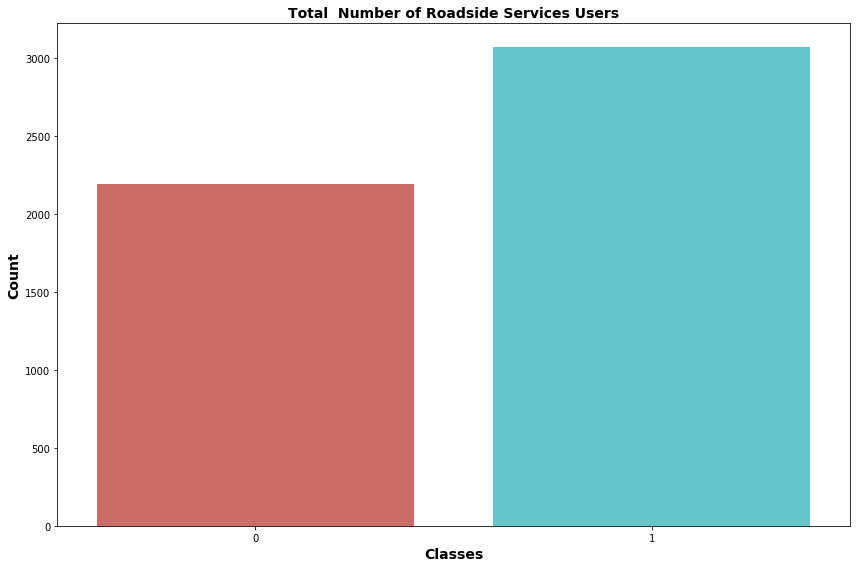

In [101]:
plt.figure(figsize=(12,8))
sns.countplot(x=var_to_predict[0],data=df_household, palette='hls')
plt.title('Total  Number of '+var_to_predict_title + ' Users',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.ylabel("Count",fontsize=14, fontweight='bold')
plt.xlabel("Classes", fontsize=14, fontweight='bold')
plt.savefig(var_to_predict_save+'_count_plot')
plt.show()

In [102]:
# Number of members in household key
df_household.total_members_in_household.value_counts()

2     1907
1     1523
3      932
4      529
5      234
6       73
7       42
8        9
9        7
10       4
15       1
Name: total_members_in_household, dtype: int64

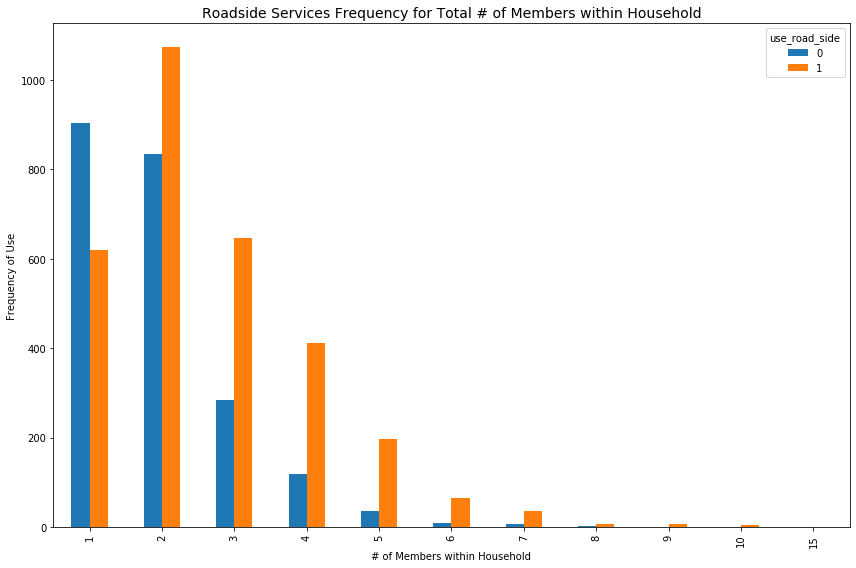

In [103]:
# graph income
pd.crosstab(df_household.total_members_in_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title + ' Frequency for Total # of Members within Household')
plt.xlabel('# of Members within Household')
plt.ylabel('Frequency of Use')
plt.savefig('members_hh_use_'+var_to_predict_save)
plt.show()

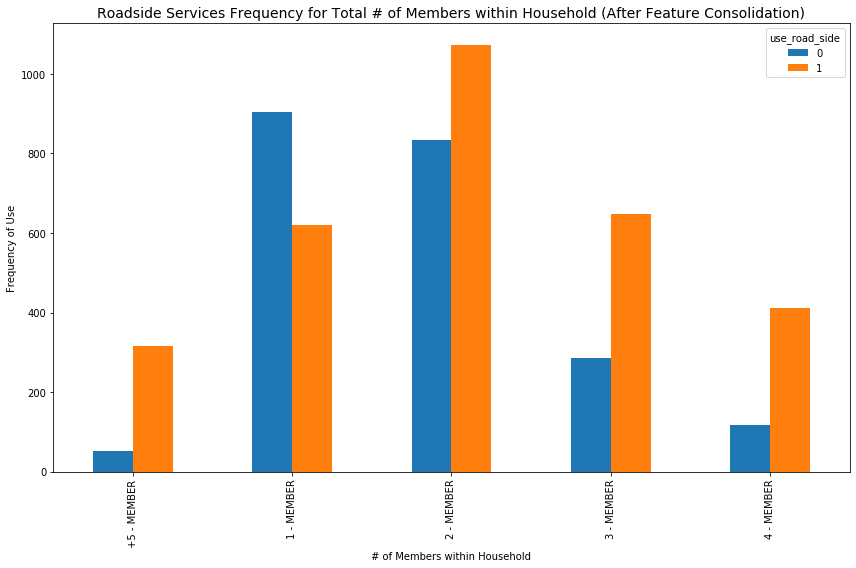

In [104]:
# Number of members

df_household['no_members'] = ' '
df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                    df_household['no_members'])
df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                    df_household['no_members'])

df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                    df_household['no_members'])
group5 = np.arange(5,20,1)
for i in group5:
    df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                    df_household['no_members'])
    
pd.crosstab(df_household.no_members,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Total # of Members within Household (After Feature Consolidation)')
plt.xlabel('# of Members within Household')
plt.ylabel('Frequency of Use')
plt.savefig('members_hh_'+var_to_predict_save+'_feat')

In [105]:
# Income
df_household.income.value_counts()

UNKNOWN          2416
100-149,999       570
90-99,999         519
70-79,999         257
50-59,999         240
10-19,999         219
40-49,999         207
30-39,999         137
20-29,999         126
175 - 199,999     126
60-69,999         121
150 - 174,999     100
200 - 249,999      86
250K+              77
UNDER 10K          58
80-89,999           2
Name: income, dtype: int64

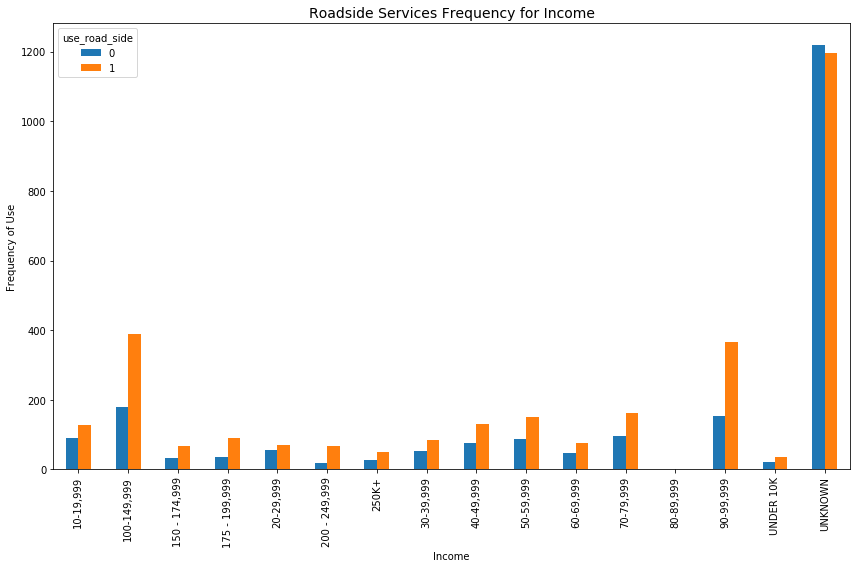

In [106]:
# graph income
pd.crosstab(df_household.income,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Income')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('income_use_'+var_to_predict_save)

# Outcomes
The frequency of id theft Service use depend heavvily on income. 
Will consolidate income in three categories: 
    * a) under 10k - 39999: Under 39.999
    * b) 40 - 99,999 : 40 - 99,999
    * c) 100k and above : 100+
    

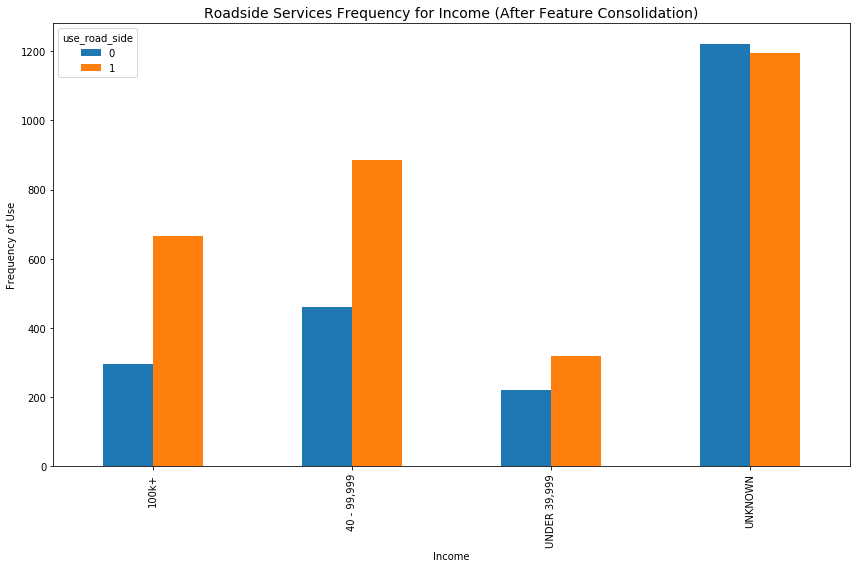

In [107]:
group1 = ['UNDER 10K', '10-19,999','20-29,999', '30-39,999']
group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
for i in group1:
    df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
for i in group2:
    df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
for i in group3:
    df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])

pd.crosstab(df_household.income,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Income (After Feature Consolidation)')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('income_use_feat_'+var_to_predict_save)

In [108]:
# Tenures
df_household.tenure.value_counts()

+40 YEARS                3174
BETWEEN 21 & 30 YEARS     470
BETWEEN 31 & 40 YEARS     420
BETWEEN 11 & 15 YEARS     368
BETWEEN 6 & 10 YEARS      350
BETWEEN 16 & 20 YEARS     308
BETWEEN 1 & 5 YEARS       160
< 1 YEAR                   11
Name: tenure, dtype: int64

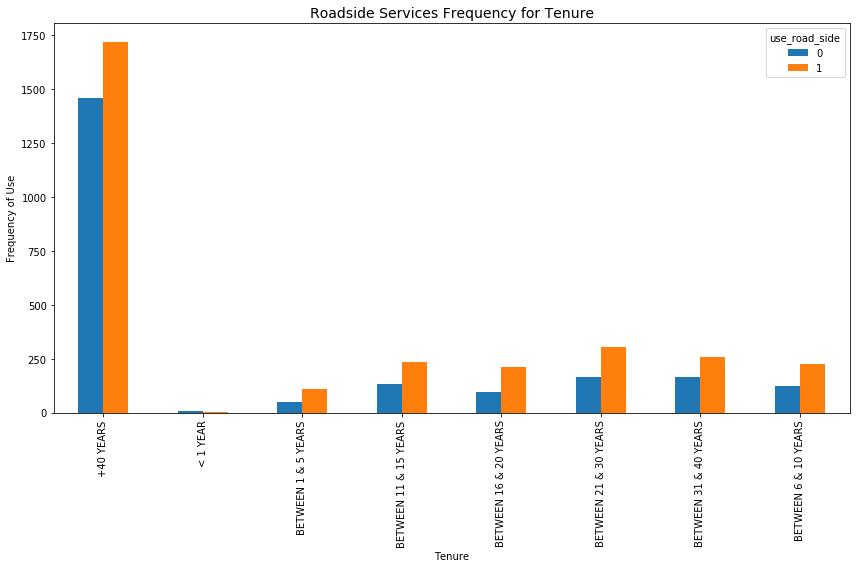

In [109]:
# graph tenure
pd.crosstab(df_household.tenure,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Tenure')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('tenure_use_'+var_to_predict_save)

# Outcomes
The frequency of id theft Service use depend heavily on tenures. Will consolidate tenure in three categories: 
    * a) above 40 years  
    * b) between 21 - 40 
    * c) Less 21 


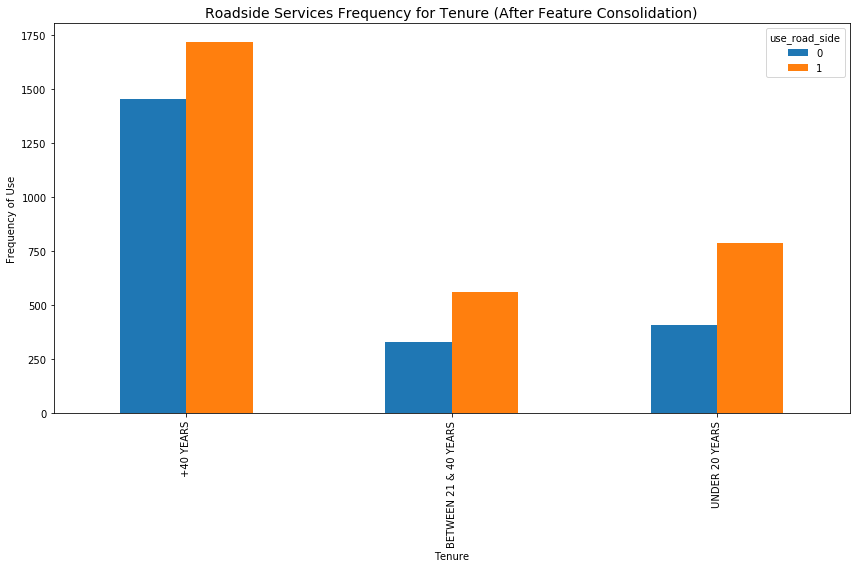

In [110]:
group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
group3 = ['+40 YEARS']
for i in group1:
    df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
for i in group2:
    df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
for i in group3:
    df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])

pd.crosstab(df_household.tenure,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Tenure (After Feature Consolidation)')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('tenure_use_feat_'+var_to_predict_save)

In [111]:
# Credit Ranges
df_household.credit_ranges.value_counts()

UNKNOWN       2513
750-799        992
700-749        596
650-699        456
800+           410
600-649        205
550-599         50
500-549         35
499 & LESS       4
Name: credit_ranges, dtype: int64

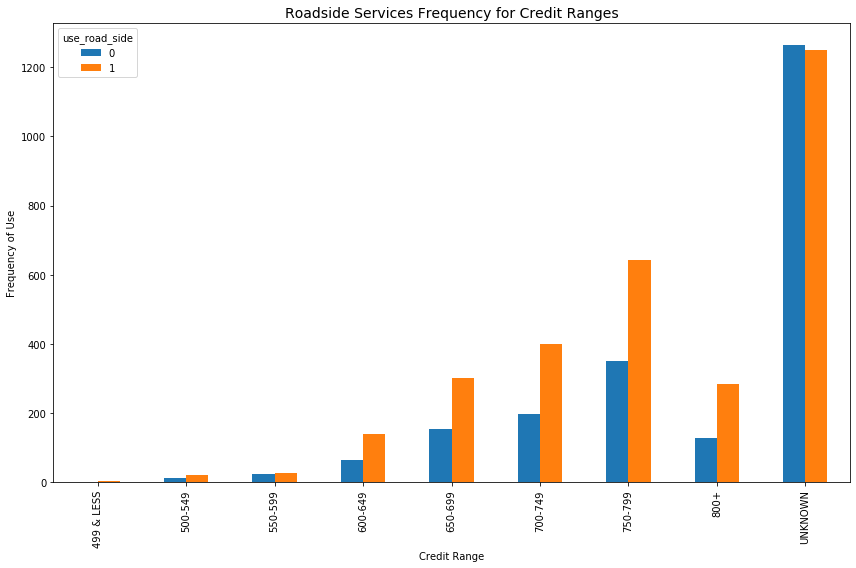

In [112]:
# graph credit ranges
pd.crosstab(df_household.credit_ranges,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Ranges')
plt.xlabel('Credit Range')
plt.ylabel('Frequency of Use')
plt.savefig('credit_ranges_use_'+var_to_predict_save)

# Outcomes
The frequency of id theft Service use depend heavily on credit_ranges. Will consolidate tenure in three categories: 
    * a) above 800 years 
    * b) between 700 - 799 
    * c) Below 700

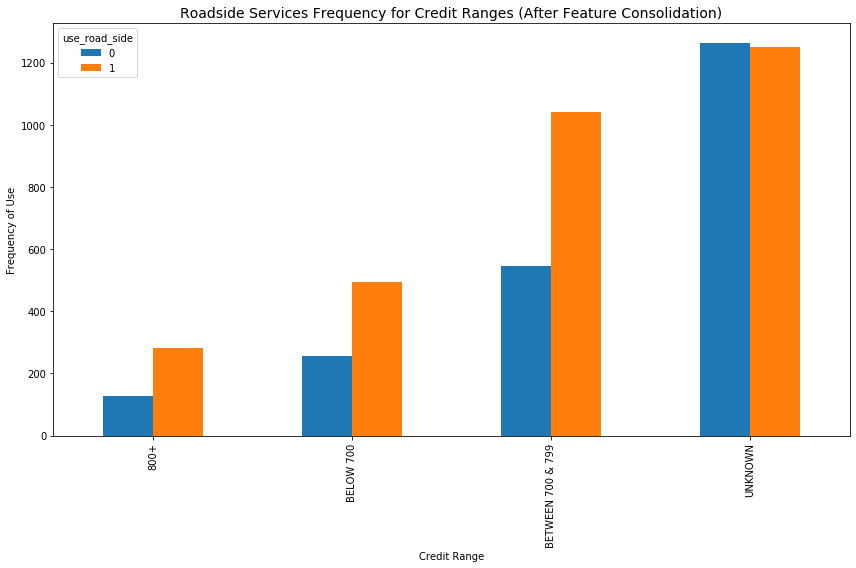

In [113]:
group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
group2 = ['700-749', '750-799']
group3 = ['800+']
for i in group1:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
for i in group2:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
for i in group3:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])

pd.crosstab(df_household.credit_ranges,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Ranges (After Feature Consolidation)')
plt.xlabel('Credit Range')
plt.ylabel('Frequency of Use')
plt.savefig('credit_ranges_use_feat_'+var_to_predict_save)

In [114]:
# Education
df_household.education.value_counts()

UNKNOWN              3299
SOME COLLEGE          783
HIGH SCHOOL           741
COMPLETED COLLEGE     396
GRADUATED SCHOOL       42
Name: education, dtype: int64

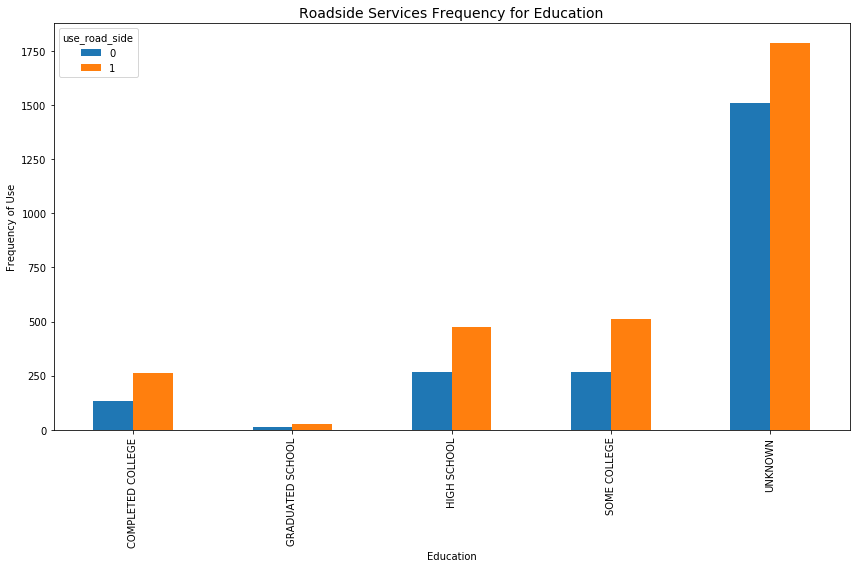

In [115]:
# graph education
pd.crosstab(df_household.education,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Education')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('education_use_'+var_to_predict_save)

# Outcomes
The frequency of id theft Service use depend heavily on education. Will consolidate graduate with completed collegue

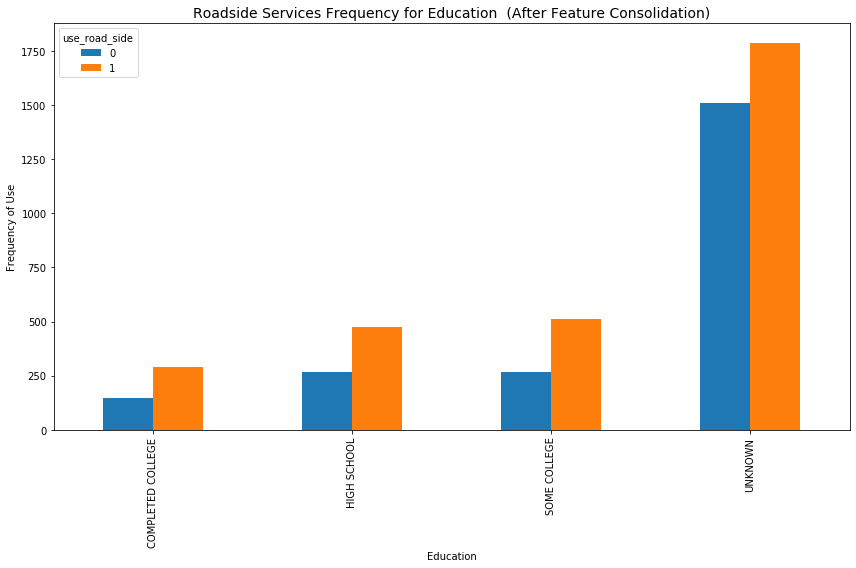

In [116]:
# graph education
df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
pd.crosstab(df_household.education,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Education  (After Feature Consolidation)')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('education_use_feat_'+var_to_predict_save)

In [117]:
# Generation
df_household.generation.value_counts()

POST-WAR (< 1948)             3155
BABY BOOMERS (1948 - 1968)     979
UNKNOWN                        724
GENERATION X (1969 - 1980)     210
MILLENIALS (1981 - 1993)       177
GENERATION Z (1994 - 2010)      16
Name: generation, dtype: int64

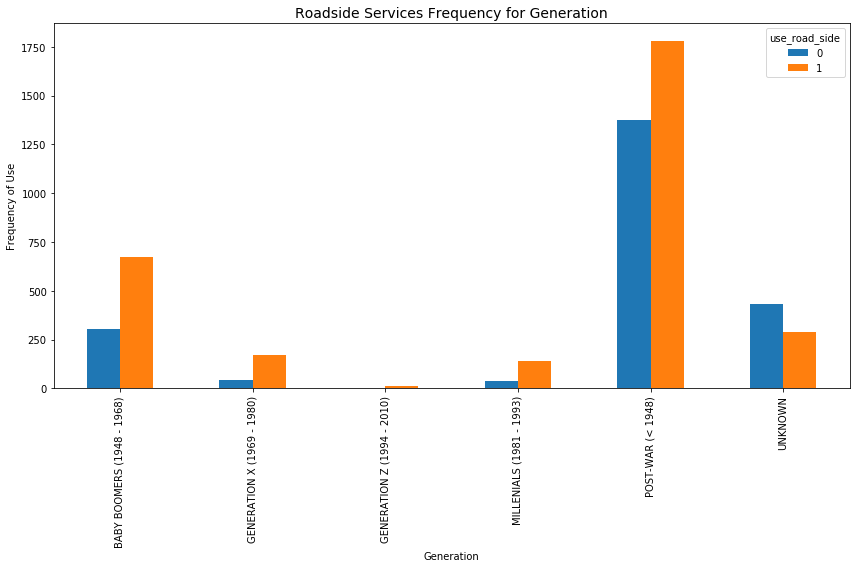

In [118]:
# graph Generation
pd.crosstab(df_household.generation,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Generation')
plt.xlabel('Generation')
plt.ylabel('Frequency of Use')
plt.savefig('generation_use_'+var_to_predict_save)

In [119]:
# Race
df_household.race.value_counts()

UNKNOWN                                   2462
CAUCASION / WHITE - EUROPEAN              1282
CAUCASION / WHITE - ENGLISH                682
CAUCASION / WHITE - WHITE NON-AMERICAN     262
CAUCASION / WHITE - UNKNOWN                116
MIDDLE EASTERN - ARAB                      107
HISPANIC - HISPANIC ORIGIN                  97
CAUCASION / WHITE - EASTERN EUROPEAN        86
HISPANIC - PORTUGUESE ORIGIN                73
CAUCASION / WHITE - JEWISH                  22
CAUCASION / WHITE - GREEK                   15
ASIAN - CHINESE                             15
ASIAN - UNKNOWN                             11
ASIAN - INDIAN                               7
AMERICAN INDIAN                              7
AFRICAN AMERICAN - AFRICAN ORIGIN            7
ASIAN - JAPANESE                             5
MIDDLE EASTERN - EGYPTIAN                    2
CAUCASION / WHITE - DUTCH                    2
ASIAN - ORIENTAL                             1
Name: race, dtype: int64

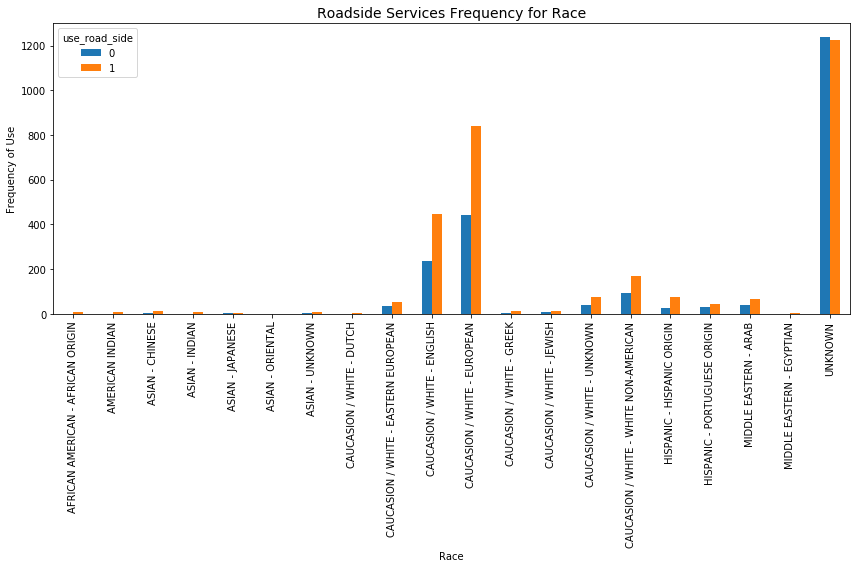

In [120]:
# graph race
pd.crosstab(df_household.race,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Race')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('race_use_'+var_to_predict_save)

# Observations
The frequency of id theft Service use depend heavily on race being caucasion- white group the predominant. 
I Will consolidate them in more similar groups
    * a) Caucasion - White
    * b) Hispanic
    * c) Asian
    * d) Arabs
    * e) America Africans / Indians

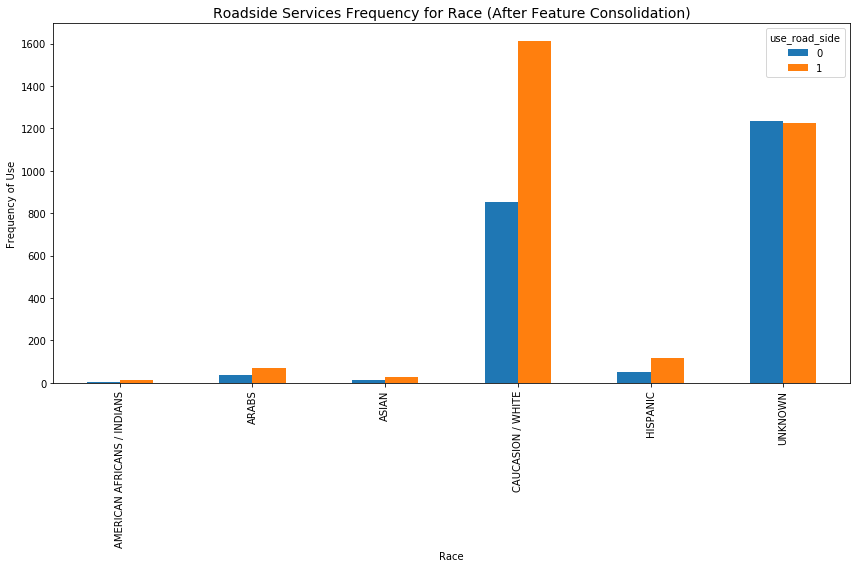

In [121]:
group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

for i in group1:
    df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
for i in group2:
    df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
for i in group3:
    df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
for i in group4:
    df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
for i in group5:
    df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

pd.crosstab(df_household.race,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Race (After Feature Consolidation)')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('race_use_feat_'+var_to_predict_save)

In [122]:
# Home Owner
df_household.home_owner.value_counts()

HOME OWNER             2626
UNKNOWN                2506
RENTER                  120
PROBABLE RENTER           6
PROBABLE HOME OWNER       3
Name: home_owner, dtype: int64

# Outcomes
The frequency of id theft Service use depend heavily on home_owner.  Will leave consolidate probable renter with RENTER and probable home owner with home owner 

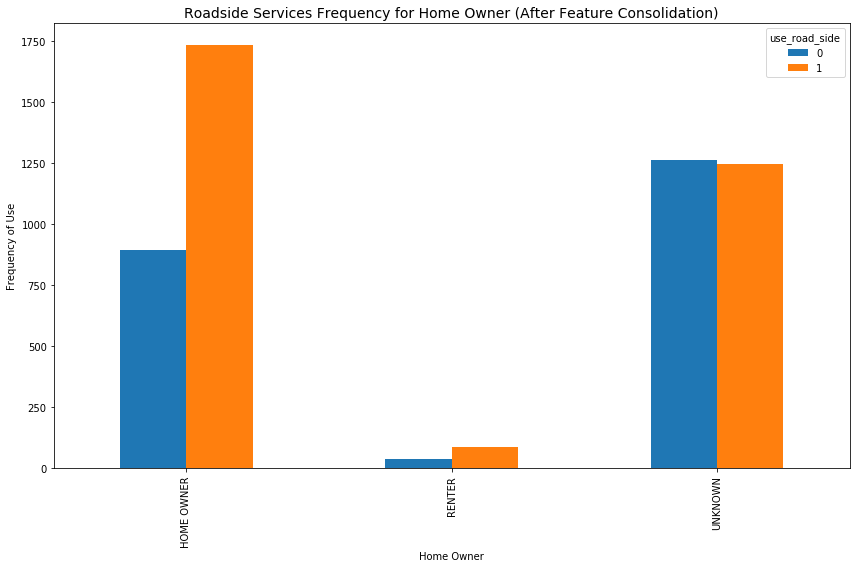

In [123]:
# Home Owner
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])

pd.crosstab(df_household.home_owner,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Home Owner (After Feature Consolidation)')
plt.xlabel('Home Owner')
plt.ylabel('Frequency of Use')
plt.savefig('home_owner_use_feat_'+var_to_predict_save)

In [124]:
# Cancel reason
df_household.cancel_reason.value_counts()

UNKNOWN                               2978
NON-PAYMENT                            885
DECEASED                               583
MEMBERS REQUEST                        320
NO LONGER DRIVING                      172
CANCELLED DO NOT RENEW                  66
TRANSFER MEMBER                         63
DUP MEMBERSHIP                          47
DATA PROBLEM                            46
TRANSFER MEMBER SUSPEND                 29
DO NOT RENEW                            20
MOVED OUT OF TERR                       15
CANCELLED MBRS REQUEST                   8
NO LONGER IN HOUSEHOLD                   5
NONCOMPLIANT AGE                         4
ERS DECLINE CC                           3
HEALTH ISSUE                             3
BAD ADD SET BY PO ACS                    2
*BAD CHECKS*                             2
NONCOMPLIANT ADDRESS                     2
PO RETURN                                1
CANCELED IN POACS PROCESS                1
ERS CNCL MSHIP PROGRAM                   1
DUPLICATE A

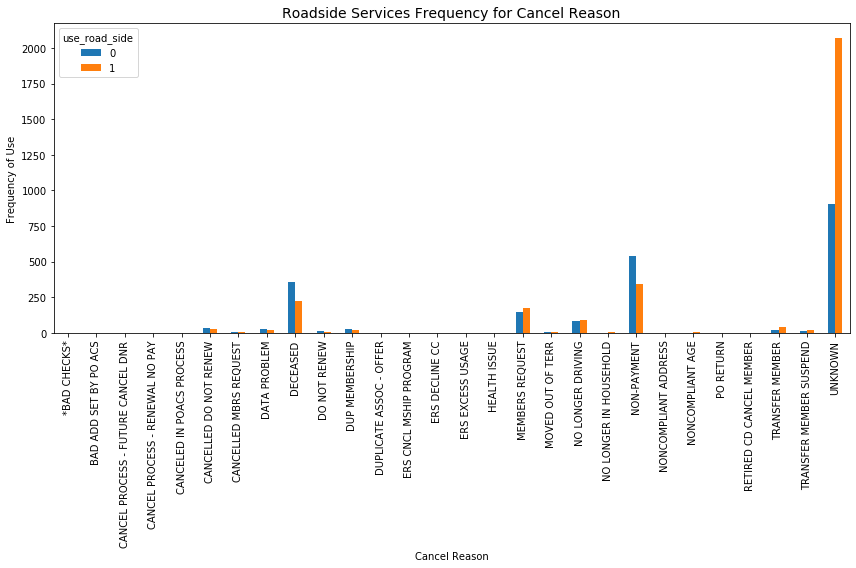

In [125]:
# graph Cancel Reason
pd.crosstab(df_household.cancel_reason,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Cancel Reason')
plt.xlabel('Cancel Reason')
plt.ylabel('Frequency of Use')
plt.savefig('cancel_reason_use_'+var_to_predict_save)

# Observation
This Cancel Reason feature does not seems to be important to weather member choose or not id theft. Even though, for instance those member that their suscription was cancelled or CC rejected, there might be an oportunity to get a CC if credit is available to them.  Will consolidate the reason in three main groups:
* a) PAYMENT ISSUES
* b) MEMBER ISSUES
* c) DATA/AAA ISSUES

UKNOWN will be replaced by 'NOT CANCELLED'  It is the largest group and a potential to customer.

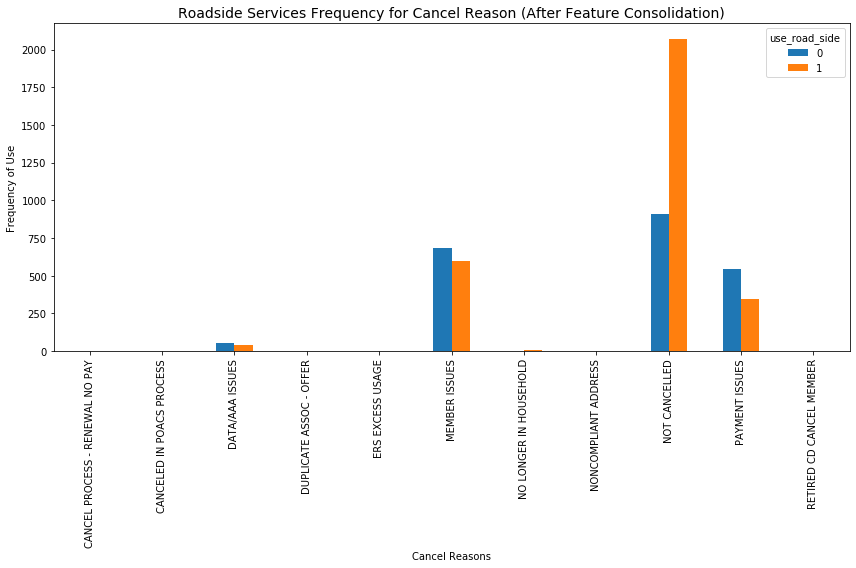

In [126]:
group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
          'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
          'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
         ]
group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

for i in group1:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
for i in group2:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
for i in group3:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

df_household['cancel_reason']=np.where(df_household['cancel_reason']== 'UNKNOWN', 'NOT CANCELLED', df_household['cancel_reason'])

pd.crosstab(df_household.cancel_reason,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Cancel Reason (After Feature Consolidation)')
plt.xlabel('Cancel Reasons')
plt.ylabel('Frequency of Use')
plt.savefig('cancel_reason_use_feat_'+var_to_predict_save)

In [127]:
# mosaic_household
df_household.mosaic_household.value_counts()

UNKNOWN                       1525
AGING IN PLACE                 690
SILVER SOPHISTICATES           331
REAPING REWARDS                246
NO PLACE LIKE HOME             234
ROOTED FLOWER POWER            220
TOWN ELDERS                    198
SENIOR DISCOUNTS               173
AGING OF AQUARIUS              156
SETTLED IN SUBURBIA            143
FULL POCKETS  EMPTY NESTS      118
DIGITAL DEPENDENTS             105
FAST TRACK COUPLES              71
BOHEMIAN GROOVE                 69
BLUE COLLAR COMFORT             69
PLATINUM PROSPERITY             62
FAMILY FUN-TASTIC               61
AMERICAN ROYALTY                59
PROGRESSIVE POTPOURRI           53
STATUS SEEKING SINGLES          45
BOOMERS AND BOOMERANGS          44
GOLF CARTS AND GOURMETS         42
BIRKENSTOCKS AND BEEMERS        42
PICTURE PERFECT FAMILIES        40
UNSPOILED SPLENDOR              40
MID-SCALE MEDLEY                38
COUPLES WITH CLOUT              28
SETTLED AND SENSIBLE            27
TOUGH TIMES         

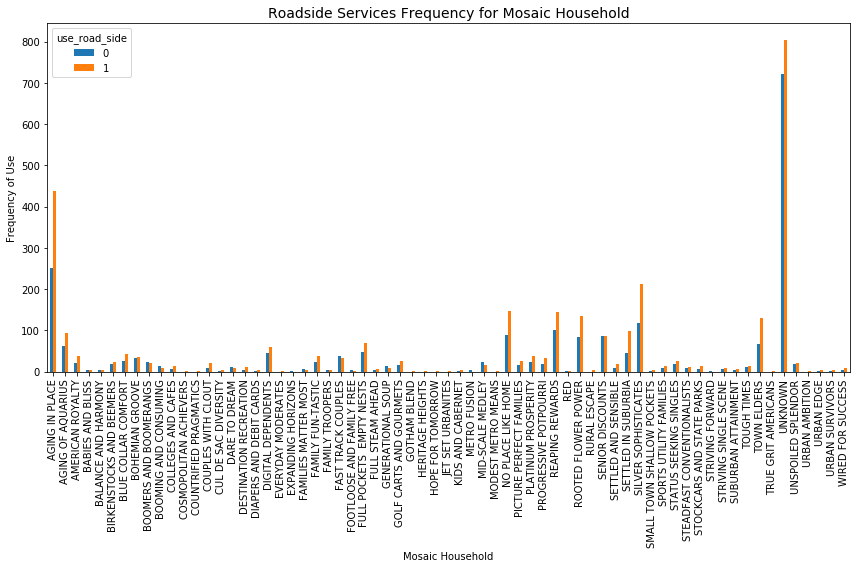

In [128]:
# graph Mosaic household
pd.crosstab(df_household.mosaic_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mosaic Household')
plt.xlabel('Mosaic Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_household_use_'+var_to_predict_save)

In [129]:
# mosaic_household
df_household.mosaic_global_household.value_counts()

UNKNOWN                      1525
COMFORTABLE RETIREMENT       1176
BOURGEOIS PROSPERITY          839
ROUTINE SERVICE WORKERS       552
HARD WORKING BLUE COLLAR      265
CAREER AND FAMILY             248
POST INDUSTRIAL SURVIVORS     229
LOW INCOME ELDERS             223
METROPOLITAN STRUGGLERS       137
SOPHISTICATED SINGLES          64
RURAL INHERITANCE               3
Name: mosaic_global_household, dtype: int64

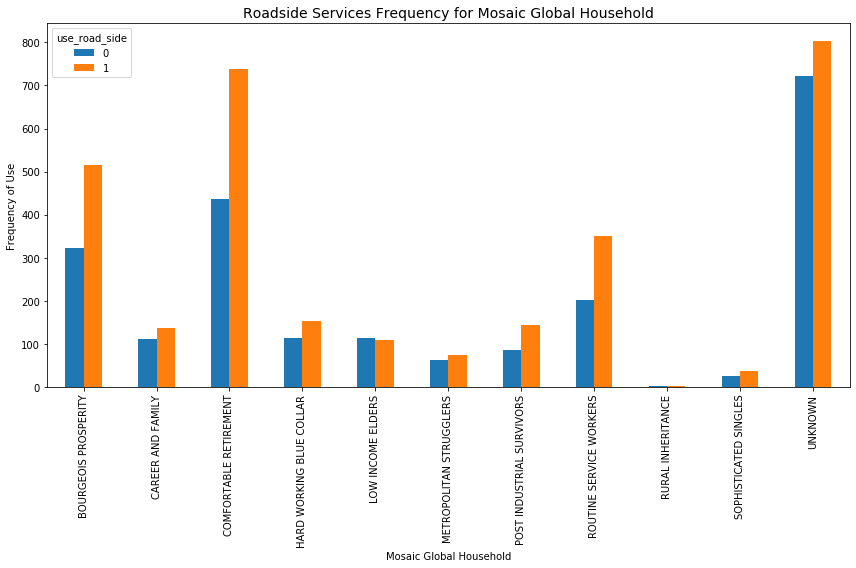

In [130]:
# graph Mosaic Global household
pd.crosstab(df_household.mosaic_global_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mosaic Global Household')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_global_household_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, these three groups can be consolidated in:
* a) METROPOLITAN STRUGGLERS into ROUTINE SERVICE WORKERS
* b) SOPHISTICATED SINGLES into BOURGEOIS PROSPERITY
* c) RURAL INHERITANCE into CAREER AND FAMILY
* d) POST INDUSTRIAL SURVIVORS into ROUTINE SERVICE WORKERS

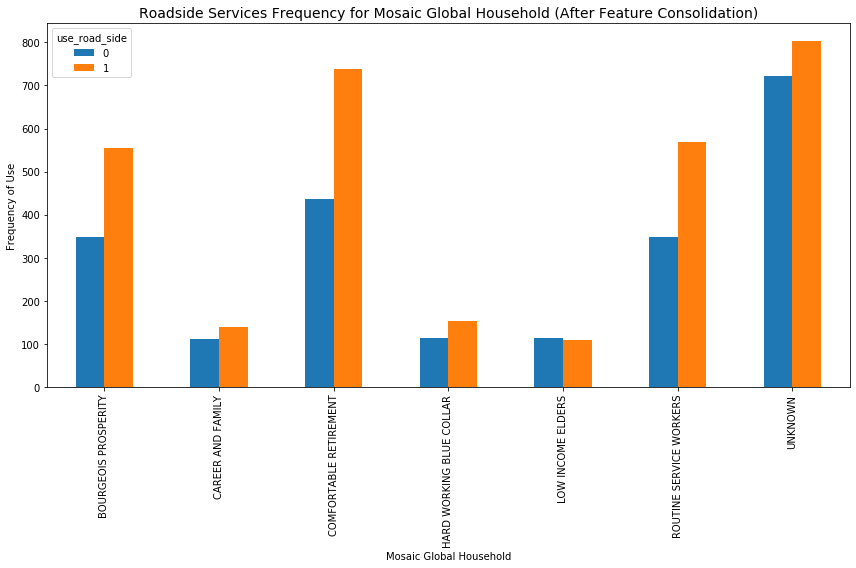

In [131]:
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                 'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                 'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                )
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

pd.crosstab(df_household.mosaic_global_household,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))

plt.title(var_to_predict_title+' Frequency for Mosaic Global Household (After Feature Consolidation)')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_global_household_use_feat_'+var_to_predict_save)

In [132]:
# kcl_b_ind_mosaicsgrouping
df_household.kcl_b_ind_mosaicsgrouping.value_counts()

UNKNOWN                     1525
AUTUMN YEARS                 721
GOLDEN YEAR GUARDIANS        621
BOOMING WITH CONFIDENCE      573
THRIVING BOOMERS             392
BLUE SKY BOOMERS             241
POWER ELITE                  194
SURBURBAN STYLE              179
SINGLES AND STARTERS         161
FAMILY UNION                 115
MIDDLE CLASS MELTING POT     113
FLOURISHING FAMILIES          95
SIGNIFICANT SINGLES           87
PROMISING FAMILIES            83
YOUNG CITY SOLOS              51
CULTURAL CONNECTIONS          44
ECONOMIC CHALLENGES           34
ASPIRATIONAL FUSION           22
FAMILIES IN MOTION             8
PASTORAL PRIDE                 2
Name: kcl_b_ind_mosaicsgrouping, dtype: int64

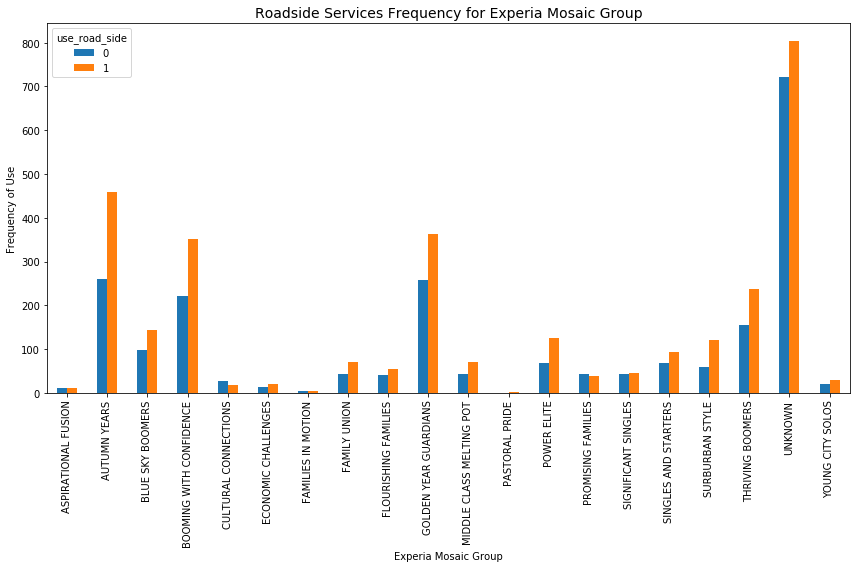

In [133]:
# graph kcl_b_ind_mosaicsgrouping
pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Experia Mosaic Group')
plt.xlabel('Experia Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('kcl_b_ind_mosaicsgrouping_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are five dominant group here
* a) GOLDEN YEARS - retired people
* b) BOOMING - well established families
* c) POWER ELITE - powerufull wealth people
* d) FAMILY - middle class families
* e) Singles - singles or single moms.

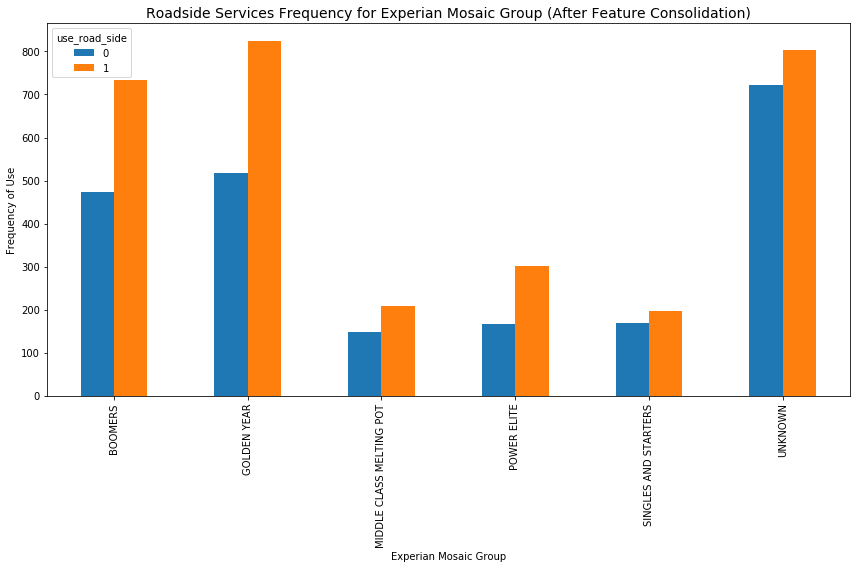

In [134]:
group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
          'PASTORAL PRIDE']
group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
         'ASPIRATIONAL FUSION']
for i in group1:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group2:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group3:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group4:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group5:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])

pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))

plt.title(var_to_predict_title+' Frequency for Experian Mosaic Group (After Feature Consolidation)')
plt.xlabel('Experian Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('kcl_b_ind_mosaicsgrouping_use_feat_'+var_to_predict_save)

In [135]:
# Vehicle Manufacturer
df_household.sc_vehicle_manufacturer_name.value_counts()

UNKNOWN          2605
TOYOTA            487
HONDA             322
FORD              290
CHEVROLET         194
HYUNDAI           140
NISSAN            119
BUICK             110
SUBARU             86
JEEP               79
DODGE              75
CHRYSLER           73
MERCURY            59
LEXUS              59
MERCEDES-BENZ      51
KIA                48
VOLKSWAGEN         45
VOLVO              44
MAZDA              41
SATURN             36
CADILLAC           32
LINCOLN            31
GMC                31
ACURA              30
BMW                30
PONTIAC            29
OLDSMOBILE         21
AUDI               17
SAAB               16
INFINITI           15
PLYMOUTH            6
SCION               6
MITSUBISHI          6
MINI                5
LAND ROVER          5
SUZUKI              4
RAM                 3
ISUZU               2
GEO                 2
PORSCHE             2
FIAT                1
FERRARI             1
ALFA ROMEO          1
JAGUAR              1
MG                  1
Name: sc_v

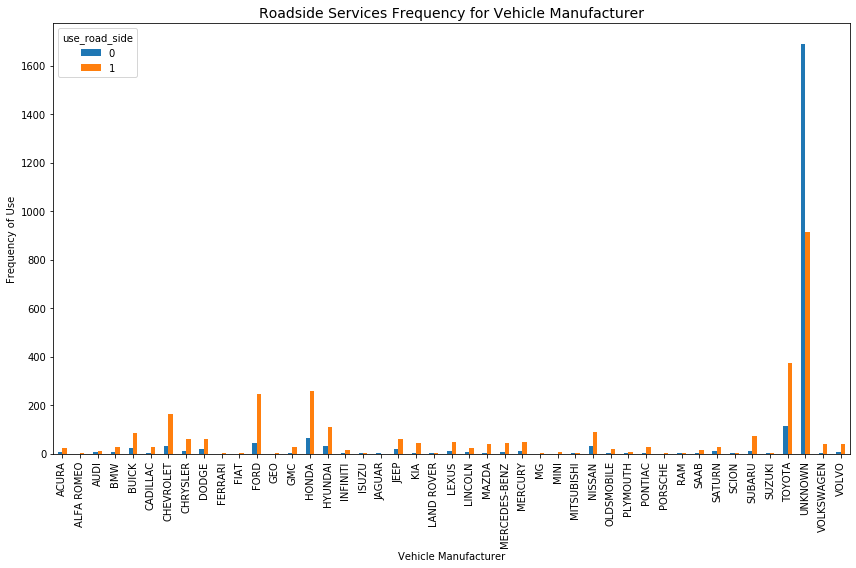

In [136]:
# graph Vehicle manufacturer
pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Vehicle Manufacturer')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('vehicle_manufacturer_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are four main group of car.  

* a) Standard for small families, and young professional, 
* b) Middle End - Middle class families and middle management
* c) High End - Success and upper management or people above 55 years no debts and no kids at school

Going to group the vehicle manufacturer in those three groups.

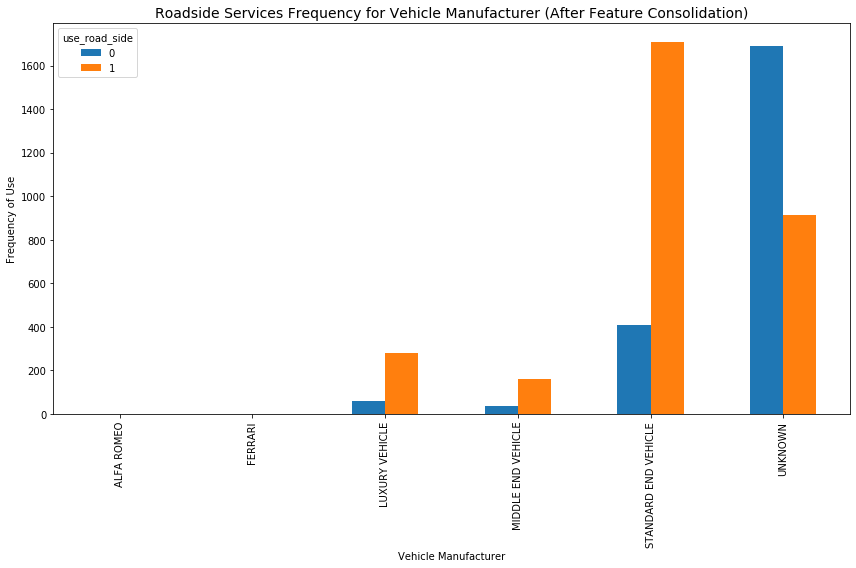

In [137]:
group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']
          
group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

for i in group1:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group2:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group3:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])


pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Vehicle Manufacturer (After Feature Consolidation)')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('vehicle_manufacturer_use_feat_'+var_to_predict_save)

In [138]:
# Occupation Code
df_household.occupation_code.value_counts()

UNKNOWN                            4364
RETIRED                             209
PROFESSIONAL/TECHNICAL              121
UPPER MANAGEMENT/EXECUTIVE           75
NURSE                                73
CLERICAL/OFFICE                      63
MIDDLE MANAGEMENT                    59
TEACHER/EDUCATOR                     55
SKILLEDTRADE/MACHINE/LABORER         50
SALES/MARKETING                      28
BEAUTY                               18
SELF EMPLOYED                        17
REAL ESTATE                          17
EXECUTIVE/ADMINISTRATOR              13
ATTORNEYS                            10
COUNSELORS                            7
RETAIL SALES                          6
PHARMACIST                            6
HEALTH SERVICES                       6
DENTIST/DENTAL HYGIENIST              6
PROFESSIONAL DRIVER                   5
OCCUPATIONAL THER/PHYSICAL THER       5
COMPUTER PROFESSIONAL                 5
ACCOUNTANTS/CPA                       5
INSURANCE/UNDERWRITERS                5


In [139]:
df_household.occupation_group.value_counts()

UNKNOWN                             3263
RETIRED - INFERRED                   633
PROFESSIONAL - KNOWN                 301
RETIRED - KNOWN                      209
MANAGEMENT - KNOWN                   160
MANAGEMENT - INFERRED                 96
BLUE COLLAR - INFERRED                80
PROFESSIONAL - INFERRED               76
OTHER - INFERRED                      74
OFFICE ADMINISTRATION - INFERRED      65
OFFICE ADMINISTRATION - KNOWN         63
BLUE COLLAR - KNOWN                   57
SALES - KNOWN                         51
OTHER - KNOWN                         44
TECHNICAL - INFERRED                  44
SALES - INFERRED                      33
TECHNICAL - KNOWN                     12
Name: occupation_group, dtype: int64

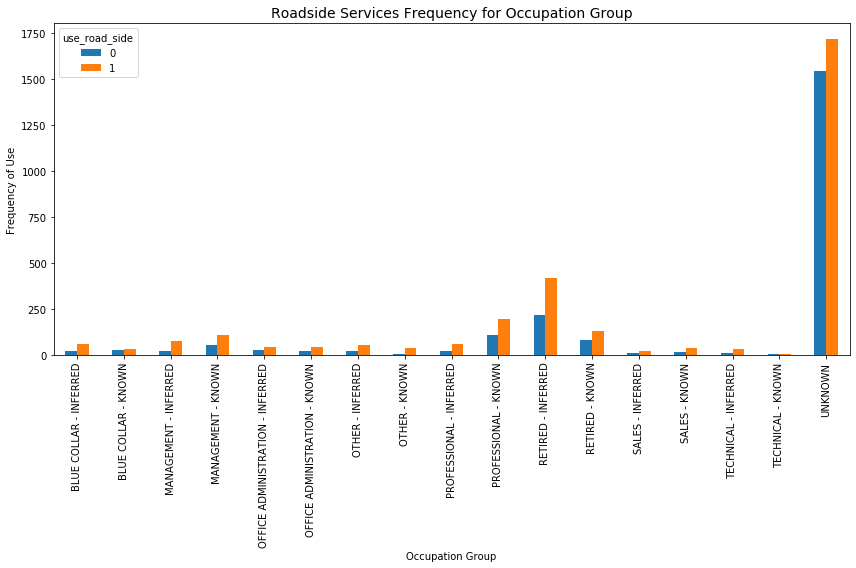

In [140]:
# graph ocuppation group
pd.crosstab(df_household.occupation_group,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Occupation Group')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('occupation_group_use_'+var_to_predict_save)

# Observation
Reviewing the graph above, there are 4 prodominat group
* a) PROFESSIONAL
* b) MANAGEMENT
* c) RETIRED
* d) OTHERS

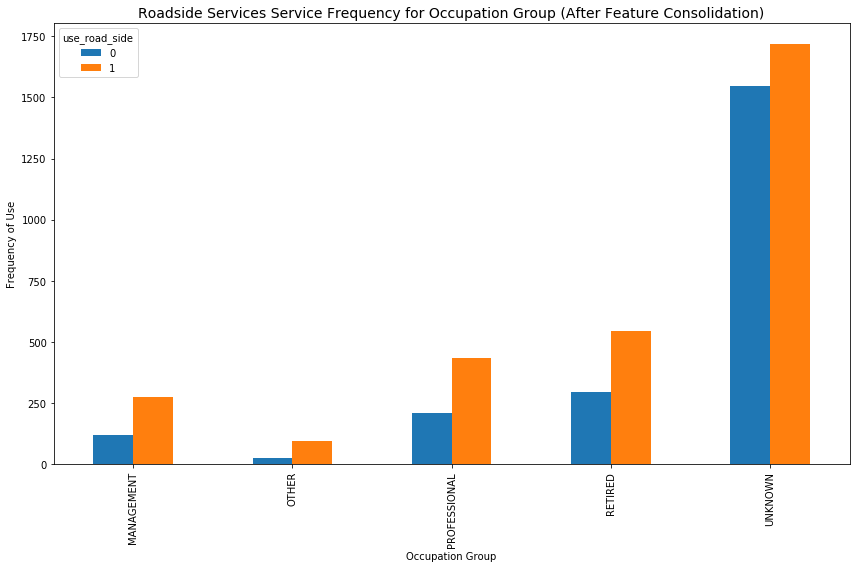

In [141]:
group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

for i in group1:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
for i in group2:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
for i in group3:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
for i in group4:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])


pd.crosstab(df_household.occupation_group,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Service Frequency for Occupation Group (After Feature Consolidation)')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('occupation_group_use_feat_'+var_to_predict_save)

In [142]:
# graph occupant type
df_household.occupant_type.value_counts()

UNKNOWN      5085
HOMEOWNER     124
RENTER         52
Name: occupant_type, dtype: int64

In [143]:
# graph member status
df_household.member_status.value_counts()

ACTIVE       2693
CANCELLED    2283
PENDING       285
Name: member_status, dtype: int64

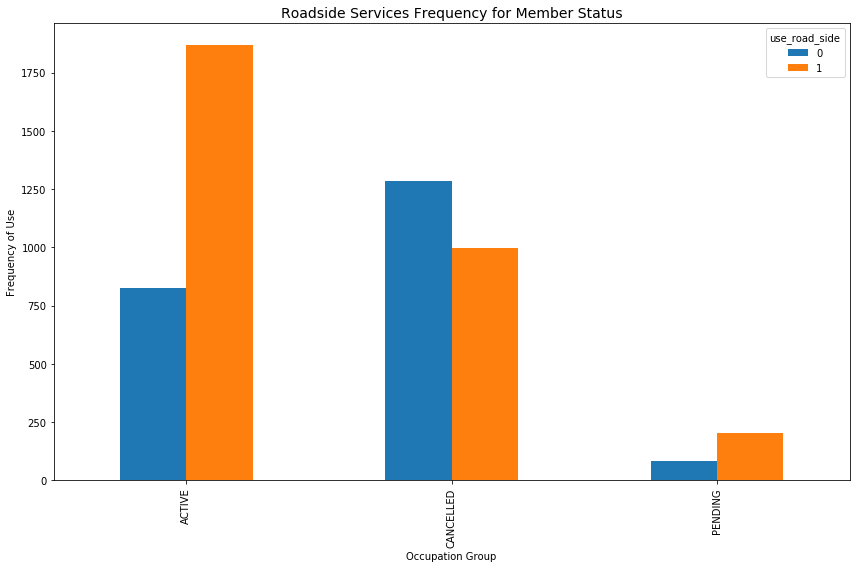

In [144]:
# graph member status group
pd.crosstab(df_household.member_status,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Member Status')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('member_status_use_'+var_to_predict_save)

In [145]:
# graph deposit
df_household.aaa_deposit.value_counts()

0    5233
1      28
Name: aaa_deposit, dtype: int64

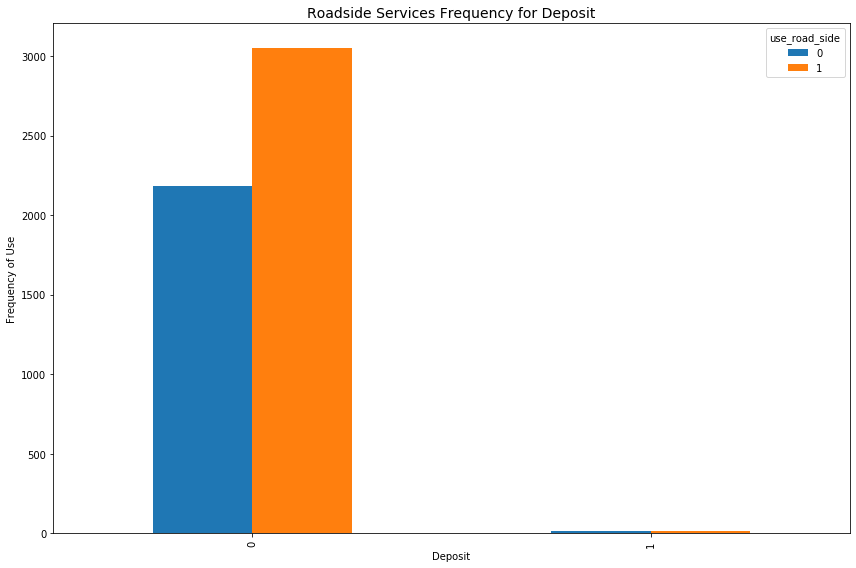

In [146]:
# graph Deposit
pd.crosstab(df_household.aaa_deposit,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Deposit')
plt.xlabel('Deposit')
plt.ylabel('Frequency of Use')
plt.savefig('deposit_use_'+var_to_predict_save)

In [147]:
# graph Financial service
df_household.aaa_financial_service.value_counts()

0    4893
1     368
Name: aaa_financial_service, dtype: int64

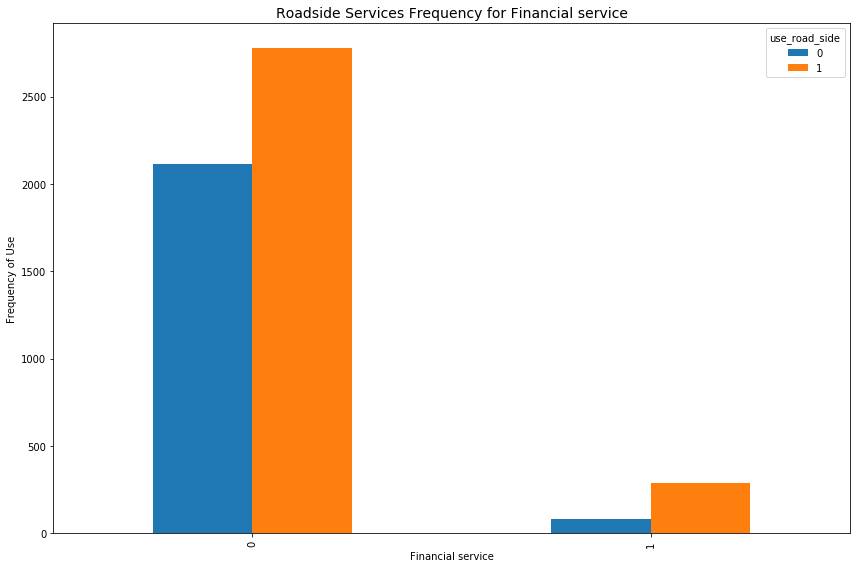

In [148]:
# graph Financial service
pd.crosstab(df_household.aaa_financial_service,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Financial service')
plt.xlabel('Financial service')
plt.ylabel('Frequency of Use')
plt.savefig('financial_service_use_'+var_to_predict_save)

In [149]:
# graph home_equity
df_household.aaa_home_equity.value_counts()

0    5255
1       6
Name: aaa_home_equity, dtype: int64

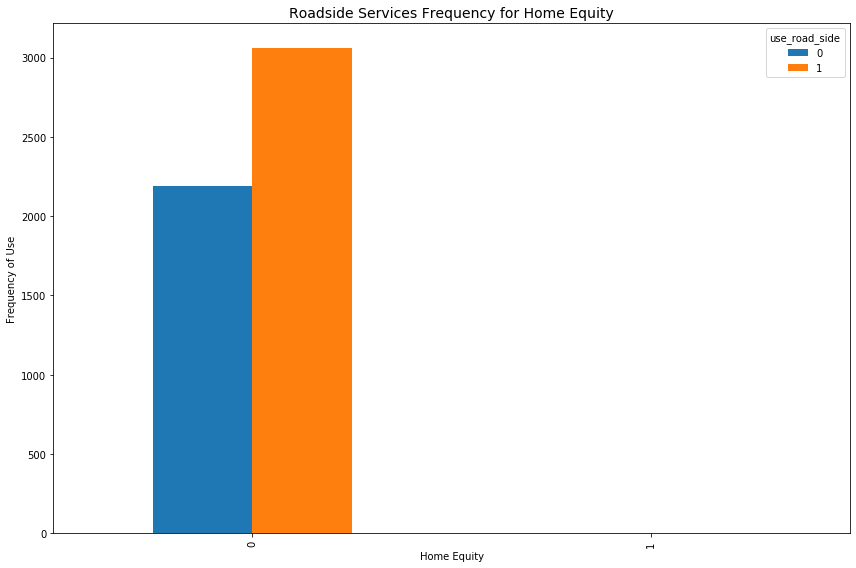

In [150]:
# graph home_equity
pd.crosstab(df_household.aaa_home_equity,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Home Equity')
plt.xlabel('Home Equity')
plt.ylabel('Frequency of Use')
plt.savefig('home_equity_use_'+var_to_predict_save)

In [151]:
# graph mortgage
df_household.aaa_mortgage.value_counts()

0    4893
1     368
Name: aaa_mortgage, dtype: int64

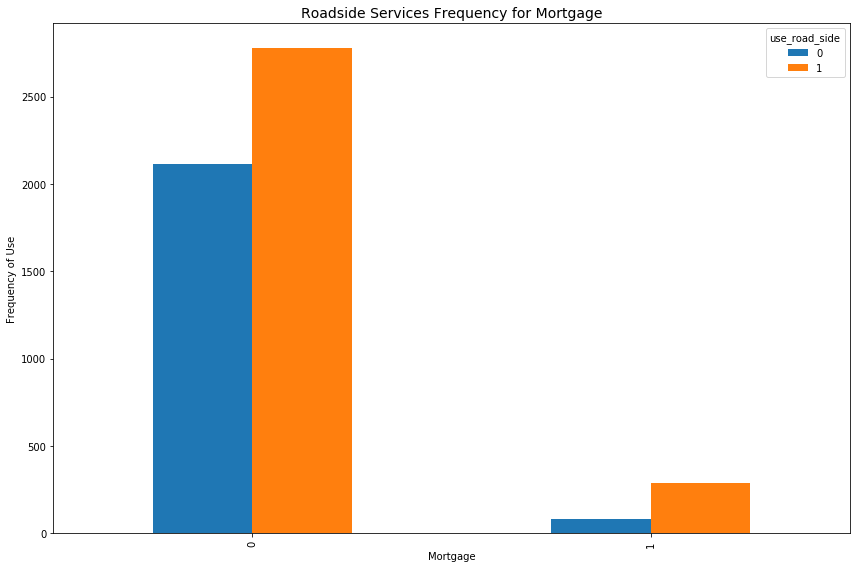

In [152]:
# graph Mortgage group
pd.crosstab(df_household.aaa_mortgage,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Mortgage')
plt.xlabel('Mortgage')
plt.ylabel('Frequency of Use')
plt.savefig('mortgage_use_'+var_to_predict_save)

In [153]:
# graph credit card
df_household.aaa_credit_card.value_counts()

0    4681
1     580
Name: aaa_credit_card, dtype: int64

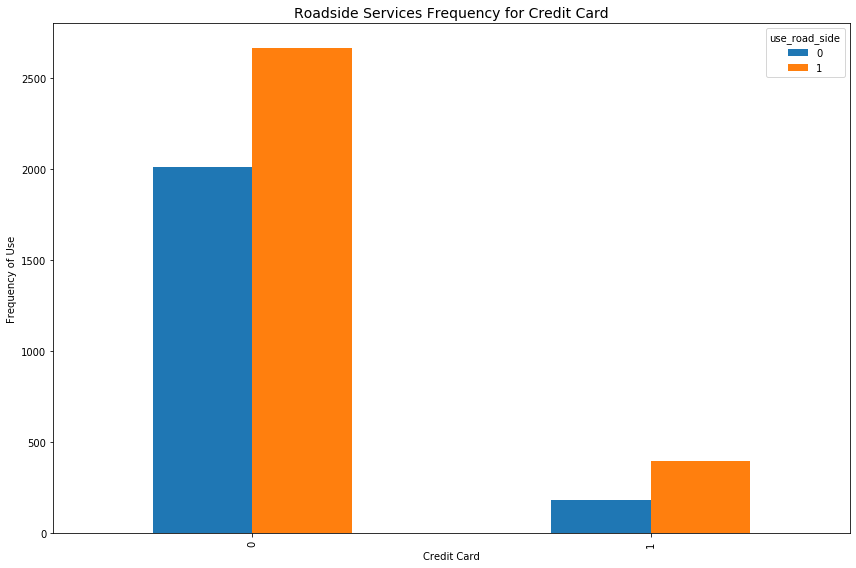

In [154]:
# graph Credit card group
pd.crosstab(df_household.aaa_credit_card,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Credit Card')
plt.xlabel('Credit Card')
plt.ylabel('Frequency of Use')
plt.savefig('credit_card_use_'+var_to_predict_save)

In [155]:
# graph auto insurance
df_household.aaa_auto_insurance.value_counts()

0    3816
1    1445
Name: aaa_auto_insurance, dtype: int64

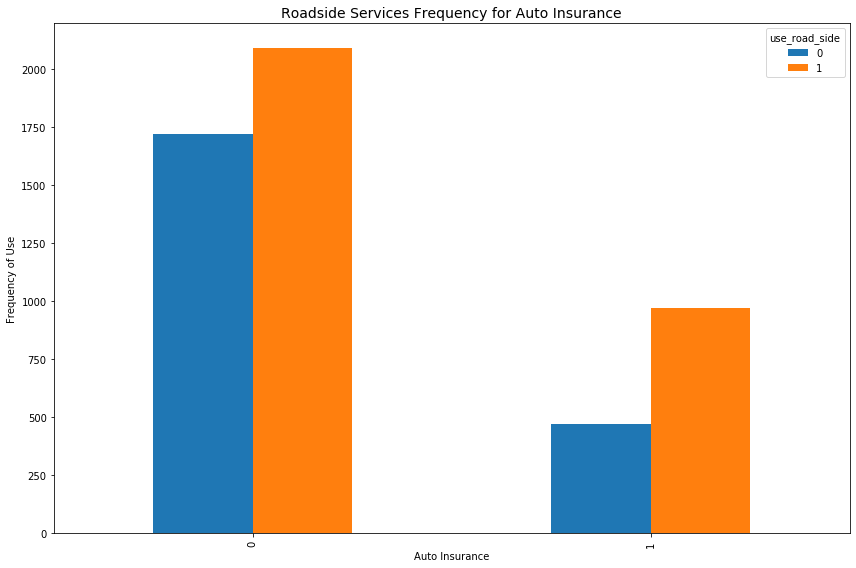

In [156]:
# graph auto insurance group
pd.crosstab(df_household.aaa_auto_insurance,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for Auto Insurance')
plt.xlabel('Auto Insurance')
plt.ylabel('Frequency of Use')
plt.savefig('auto_insurance_use_'+var_to_predict_save)

In [157]:
# graph id theft service
df_household.aaa_id_theft.value_counts()

0    5026
1     235
Name: aaa_id_theft, dtype: int64

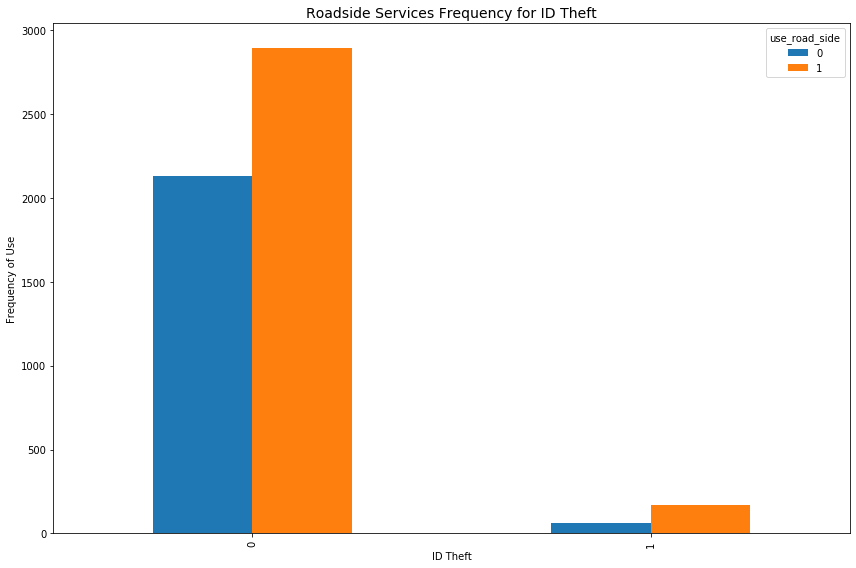

In [158]:
# graph id theft service
pd.crosstab(df_household.aaa_id_theft,df_household[var_to_predict[0]]).plot(kind='bar', figsize=(12,8))
plt.title(var_to_predict_title+' Frequency for ID Theft')
plt.xlabel('ID Theft')
plt.ylabel('Frequency of Use')
plt.savefig('id_theft_use_'+var_to_predict_save)

# Model to predict Roadside Service Usage by household key

Previous Columns Used
* cols_house_dummmies = ['income', 'tenure', 'credit_ranges','education', 'generation', 'cancel_reason',
                       'race', 'home_owner', 'dwelling_type', 'mosaic_global_household',
                       'plus_indicator_description', 'gender', 'mosaic_household',
                       'kcl_b_ind_mosaicsgrouping', 'sc_vehicle_manufacturer_name'
                       occupation_code, occupation_group, occupant_type, vehicle, sc_vehicle_model_name

* feature_cols = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                    'total_calls', 'total_member_cost', 'total_cost', 'mean_total_member_cost', 'mean_total_cost'
* feature_cols = ['no_members', 'total_calls', 'mean_total_member_cost', 'mean_total_cost',
               'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost']

# Final Observation (Need update)

Based on the previous anlysis, these are the most important feature:
* income
* tenure
* credit_ranges
* education
* generation
* race
* home_owner
* cancel_reason
* mosaic_global_household
* plus_indicator_description
* Gender
* kcl_b_ind_mosaicsgrouping
* sc_vehicle_manufacturer_name
* occupation_group


In [159]:
# Re initiate all features and data
def reiniciar(df_household):
    df_household = read_data('household_view.csv')
    
    # Regroup Group Income
    group1 = ['UNDER 10K','10-19,999' , '20-29,999', '30-39,999']
    group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
    group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
    for i in group1:
        df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
    for i in group2:
        df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
    for i in group3:
        df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])
    
    # Regroup tenures
    group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
    group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
    group3 = ['+40 YEARS']
    for i in group1:
        df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
    for i in group2:
        df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
    for i in group3:
        df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])
    
    # Regroup credit ranges
    group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
    group2 = ['700-749', '750-799']
    group3 = ['800+']
    for i in group1:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
    for i in group2:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
    for i in group3:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    
    # Regroup Education
    df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
    # Regroup Race
    group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
    group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
    group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
    group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
    group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

    for i in group1:
        df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
    for i in group2:
        df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
    for i in group3:
        df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
    for i in group4:
        df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
    for i in group5:
        df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

    # Regroup Home Owner
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])
    
    # Regroup Cancel reason
    group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
    group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
              'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
              'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
             ]
    group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

    for i in group1:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
    for i in group2:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
    for i in group3:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

    # Regroup Mosaic Global household
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                     'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                    )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                     'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                    )
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                     'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                    )
    # Regroup Experian Group
    group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
    group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
    group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
    group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
              'PASTORAL PRIDE']
    group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
             'ASPIRATIONAL FUSION']
    for i in group1:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group2:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group3:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group4:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group5:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])
    
    # Regroup Vehicle Manufaturer
    group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
    group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']

    group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
              'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

    for i in group1:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group2:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group3:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])

    # Regroup Occupation Group
    group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
    group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
    group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
    group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

    for i in group1:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
    for i in group2:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
    for i in group3:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
    for i in group4:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])

    # Regroup Total members inside a household
    df_household['no_members'] = ' '
    df_household['no_members']=np.where(df_household['total_members_in_household']== 1, '1 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 2, '2 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 3, '3 - MEMBER', 
                                        df_household['no_members'])
    df_household['no_members']=np.where(df_household['total_members_in_household']== 4, '4 - MEMBER', 
                                        df_household['no_members'])

    df_household['no_members']=np.where(df_household['total_members_in_household']> 4, '5 - MEMBER', 
                                        df_household['no_members'])
    group5 = np.arange(5,20,1)
    for i in group5:
        df_household['no_members']=np.where(df_household['total_members_in_household']== i, '+5 - MEMBER', 
                                        df_household['no_members'])
    
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))
    return df_household

In [160]:
df_household.groupby(by=var_to_predict)['total_cost'].mean()

use_road_side
0    27.5811
1   195.1978
Name: total_cost, dtype: float64

In [161]:
df_household.groupby(by=var_to_predict)['total_calls'].mean()

use_road_side
0    0.0000
1   13.1278
Name: total_calls, dtype: float64

In [162]:
df_household.groupby(by=var_to_predict)['total_member_cost'].mean()

use_road_side
0     0.6527
1   698.4853
Name: total_member_cost, dtype: float64

In [163]:
df_household.groupby(by=var_to_predict)['basic_cost'].mean()

use_road_side
0    25.3556
1   175.6756
Name: basic_cost, dtype: float64

In [164]:
df_household.groupby(by=var_to_predict)['plus_cost'].mean()

use_road_side
0    1.8195
1   14.3880
Name: plus_cost, dtype: float64

In [165]:
df_household.groupby(by=var_to_predict)['premier_cost'].mean()

use_road_side
0   0.0369
1   0.0049
Name: premier_cost, dtype: float64

# Reload data to conduct another experiment

In [78]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 86 columns):
membership_id                        int64
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household

In [ ]:
* Full features
cols_house_dummmies = ['income', 'credit_ranges','education', 'generation', 'aaa_financial_service',
                       'aaa_deposit', 'plus_indicator_description', 'aaa_credit_card', 'occupation_group',
                       'sc_vehicle_manufacturer_name', 'kcl_b_ind_mosaicsgrouping','dwelling_type',
                       'aaa_motorcycle_indicator', 'mosaic_global_household', 'tenure', 'aaa_auto_insurance',
                       'aaa_id_theft', 'no_members'
             ]
feature_cols = ['total_calls', 'mean_total_member_cost', 'mean_total_cost', 'aaa_mean_child',
               'mean_basic_cost', 'mean_plus_cost', 'mean_premier_cost', 'length_of_residence'
               ]

In [166]:
df_household.groupby(by=['use_road_side', 'length_of_residence']).mean()

membership_id  household_key       zip  aaa_no_tenure  aaa_member_tenure_years  aaa_mean_age  aaa_mortgage  aaa_credit_card  aaa_deposit  aaa_home_equity  aaa_financial_service  aaa_auto_insurance  aaa_id_theft  aaa_motorcycle_indicator  aaa_travel  aaa_mean_child  aaa_mean_total_cost  aaa_no_race  aaa_no_home_owner  aaa_no_education  aaa_no_income  aaa_no_dwelling_type  aaa_no_credit_ranges  aaa_no_gender  aaa_no_language  aaa_no_reason_joined  aaa_cancel_reason  aaa_no_mosaic_household  aaa_no_mosaic_global_household  aaa_no_kcl_b_ind_mosaicsgrouping  aaa_no_occupation_code  aaa_no_occupation_group  aaa_no_occupant_type  aaa_no_plus_indicator_description  aaa_no_generation  total_calls_year_1  total_calls_year_2  total_calls_year_3  total_member_cost_1  total_member_cost_2  total_member_cost_3  basic_cost  plus_cost  premier_cost  mean_basic_cost  mean_plus_cost  mean_premier_cost  total_calls  total_member_cost  mean_total_member_cost  \
use_road_side length_of_residence                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0             0.0000                 147901.0374  14860433.6977 3302.2975         0.9875                  47.0000       84.3349        0.0154           0.0298       0.0019           0.0010                 0.0154              0.1420        0.0077                    0.2740      0.0365          1.3654               4.0694       2.0435             0.0000            1.8182         5.3913                0.5674                2.8889         1.4444           0.5238                2.5625             3.2774                  13.7918                          3.7508                            6.2934                  9.8919                   5.0700                1.3077                             1.0519             0.3682              0.0000              0.0000              0.0000               0.0000               0.0000               1.1823      9.8383     0.6795        0.0000           3.8341          0.2232             0.0000       0.0000             1.1823                  0.1075   
              0.2500                  57877.0000   4878476.0000 2856.5000         3.5000                  45.0000       78.0000        0.0000           0.5000       0.0000           0.0000                 0.0000              1.0000        0.0000                    0.5000      0.0000          2.0000              36.1250       1.0000             0.0000            4.0000         2.0000                0.0000                2.5000         1.5000           0.0000                   nan             4.0000                   7.5000                          2.5000                            6.5000                     nan                   4.5000                   nan                             1.0000             1.0000              0.0000              0.0000              0.0000               0.0000               0.0000               0.0000    120.5000    24.0000        0.0000          30.1250          6.0000             0.0000       0.0000             0.0000                  0.0000   
              0.3333                 185609.0000   4259179.6667 2897.6667  

In [168]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 86 columns):
membership_id                        int64
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household

In [298]:
# Reload data to conduct another experiment
df_household = reiniciar(df_household)
cols_house_dummmies = ['income', 'aaa_financial_service','plus_indicator_description', 'aaa_credit_card', 
                       'occupation_group','sc_vehicle_manufacturer_name', 'tenure', 'aaa_auto_insurance',
                       'no_members', 'aaa_travel', 'gender', 'kcl_b_ind_mosaicsgrouping','education',
                       'dwelling_type'
                      ]
feature_cols = ['mean_total_calls_veh', 'consumer_score', 'mean_total_cost_veh', 'mean_total_member_cost_veh'
               ]

# Build Dummies Variables
df_dummies = pd.get_dummies(df_household, columns=cols_house_dummmies)
for i in cols_house_dummmies:
    cols = [j for j in df_dummies.columns if j.startswith(i)]
    feature_cols += cols

# construct Dataframe for prediction
feature_cols += var_to_predict
df_prediction = pd.DataFrame(df_dummies, columns=feature_cols)

# Stripping out spaces from ends of names, and replacing internal spaces with "_"
df_prediction.columns = [col.strip().replace(' ', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('&', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('+', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(',', '').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('(', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace(')', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('<', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('.', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('/', '_').lower() for col in df_prediction.columns]
df_prediction.columns = [col.strip().replace('-', '_').lower() for col in df_prediction.columns]

# Fix Nans
# Number of child
#df_prediction.aaa_mean_child.fillna(value=0, inplace=True)
df_prediction.consumer_score.fillna(value=0, inplace=True)
# Drop Unknown Columns 
cols_to_drop = [j for j in df_prediction.columns if j.endswith('unknown')]
df_prediction.drop(labels=cols_to_drop,axis=1, inplace=True)

# Save columns name for future use in modelling to split X-Input and y-Output
X_cols = df_prediction.columns[:-1]
y_cols = var_to_predict.copy()

df_prediction.head(5)

,mean_total_calls_veh,consumer_score,mean_total_cost_veh,mean_total_member_cost_veh,income_100k_,income_40___99999,income_under_39999,aaa_financial_service_0,aaa_financial_service_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_alfa_romeo,sc_vehicle_manufacturer_name_ferrari,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel_0,aaa_travel_1,gender_female,gender_male,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,education_completed_college,education_high_school,education_some_college,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,use_road_side
0,2.5485,73.0000,47.0448,132.3705,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1
1,0.1645,0.0000,0.0072,8.4416,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,2.4416,73.0000,45.2190,125.6894,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1
3,3.7444,70.0000,47.6622,208.3822,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
4,2.7175,71.0000,46.3234,144.3258,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1


In [299]:
df_prediction.describe()

,mean_total_calls_veh,consumer_score,mean_total_cost_veh,mean_total_member_cost_veh,income_100k_,income_40___99999,income_under_39999,aaa_financial_service_0,aaa_financial_service_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_alfa_romeo,sc_vehicle_manufacturer_name_ferrari,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel_0,aaa_travel_1,gender_female,gender_male,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,education_completed_college,education_high_school,education_some_college,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,use_road_side
count,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000,5261.0000
mean,1.4835,30.8749,23.7883,78.8032,0.1823,0.2558,0.1026,0.9301,0.0699,0.2874,0.2030,0.0010,0.0141,0.8898,0.1102,0.0747,0.0224,0.1226,0.1600,0.0002,0.0002,0.0642,0.0378,0.4024,0.6033,0.1692,0.2275,0.7253,0.2747,0.0703,0.2895,0.3625,0.1772,0.1006,0.8609,0.1391,0.2176,0.1616,0.2292,0.2551,0.0675,0.0890,0.0694,0.0833,0.1408,0.1488,0.0038,0.0150,0.5818,0.1097,0.5830
std,1.3279,34.1649,23.6072,71.2884,0.3861,0.4364,0.3035,0.2551,0.2551,0.4526,0.4023,0.0308,0.1178,0.3132,0.3132,0.2629,0.1481,0.3280,0.3667,0.0138,0.0138,0.2452,0.1908,0.4904,0.4893,0.3749,0.4193,0.4464,0.4464,0.2557,0.4536,0.4808,0.3818,0.3008,0.3461,0.3461,0.4127,0.3681,0.4204,0.4360,0.2509,0.2847,0.2541,0.2763,0.3479,0.3560,0.0615,0.1216,0.4933,0.3125,0.4931
min,0.0000,0.0000,0.0072,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.1645,0.0000,0.0072,8.4416,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,2.3971,0.0000,43.7769,117.0838,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
75%,2.7576,70.0000,47.0448,145.2741,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0

In [300]:
#  Correlation of AAA Mortage Service 
df_prediction.corr()

,mean_total_calls_veh,consumer_score,mean_total_cost_veh,mean_total_member_cost_veh,income_100k_,income_40___99999,income_under_39999,aaa_financial_service_0,aaa_financial_service_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_alfa_romeo,sc_vehicle_manufacturer_name_ferrari,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel_0,aaa_travel_1,gender_female,gender_male,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,education_completed_college,education_high_school,education_some_college,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,use_road_side
mean_total_calls_veh,1.0000,0.8415,0.9824,0.9971,0.1204,0.1414,0.0881,-0.0716,0.0716,0.6109,0.4977,0.0320,0.1163,-0.0713,0.0713,0.0938,0.0695,0.0834,0.1088,-0.0154,-0.0050,0.3003,0.2274,0.7650,-0.0457,-0.0097,0.0620,-0.0884,0.0884,0.0526,-0.0659,-0.0402,0.0306,0.0801,-0.0796,0.0796,0.1089,0.1552,0.0193,0.0398,0.0069,0.0069,-0.0037,0.0920,0.1019,0.1196,0.0041,0.0073,0.0536,0.0016,0.4612
consumer_score,0.8415,1.0000,0.8882,0.8275,0.1022,0.1554,0.0867,-0.0666,0.0666,0.5677,0.4385,0.0214,0.1109,-0.0737,0.0737,0.0649,0.0709,0.0877,0.1056,-0.0125,-0.0125,0.1437,-0.0134,0.8466,-0.0256,-0.0215,0.0491,-0.0844,0.0844,0.0531,-0.0526,-0.0425,0.0281,0.0664,-0.0853,0.0853,0.1237,0.1188,0.0200,0.0524,-0.0039,-0.0171,-0.0051,0.0959,0.1005,0.1236,0.0123,-0.0076,0.0435,0.0091,0.4138
mean_total_cost_veh,0.9824,0.8882,1.0000,0.9790,0.1225,0.1479,0.0889,-0.0746,0.0746,0.6238,0.4993,0.0337,0.1200,-0.0758,0.0758,0.0906,0.0754,0.0875,0.1090,-0.0006,0.0188,0.2730,0.1969,0.8037,-0.0409,-0.0115,0.0580,-0.0901,0.0901,0.0536,-0.0655,-0.0424,0.0346,0.0769,-0.0779,0.0779,0.1198,0.1468,0.0197,0.0427,0.0023,0.0029,-0.0016,0.0947,0.1060,0.1228,0.0056,0.0039,0.0505,0.0064,0.4644
mean_total_member_cost_veh,0.9971,0.8275,0.9790,1.0000,0.1201,0.1389,0.0878,-0.0724,0.0724,0.6050,0.4970,0.0320,0.1149,-0.0704,0.0704,0.0929,0.0683,0.0820,0.1078,-0.0152,0.0061,0.3087,0.2469,0.7465,-0.0482,-0.0074,0.0629,-0.0884,0.0884,0.0554,-0.0683,-0.0401,0.0313,0.0803,-0.0771,0.0771,0.1064,0.1546,0.0224,0.0359,0.0071,0.0082,-0.0028,0.0915,0.1016,0.1171,0.0041,0.0075,0.0529,0.0034,0.4593
income_100k_,0.1204,0.1022,0.1225,0.1201,1.0000,-0.2768,-0.1597,-0.0828,0.0828,0.0592,0.0738,-0.0146,0.0356,-0.0602,0.0602,0.1411,0.0216,0.1958,0.0920,-0.0065,-0.0065,0.1032,0.0045,0.0704,-0.0368,0.0443,0.0033,-0.0216,0.0216,0.0415,-0.1385,-0.0017,0.0749,0.0812,-0.0776,0.0776,0.1590,0.1981,0.1197,-0.0120,-0.0249,0.1465,-0.0882,0.2355,0.0976,0.1788,-0.0212,-0.0462,0.1957,-0.0995,0.1058
income_40___99999,0.1414,0.1554,0.1479,0.1389,-0.2768,1.0000,-0.1983,-0.0049,0.0049,0.0955,0.0734,0.0102,0.0187,-0.0676,0.0676,0.0687,0.0083,0.0704,0.1730,-0.0081,0.0235,0.0009,0.0207,0.1434,0.0382,-0.0403,-0.0086,-0.0784,0.0784,-0.0182,-0.0045,0.0155,0.0041,-0.0077,-0.0764,0.0764,0.1479,0.1225,-0.0348,0.1665,0.0125,-0.0470,-0.0401,0.1056,0.2385,0.2077,-0.0150,0.0064,0.0820,-0.0106,0.0904
income_under_39999,0.0881,0.0867,0.0889,0.0878,-0.1597,-0.1983,1.0000,0.0068,-0.0068,0.0855,0.0224,-0.0104,-0.0138,-0.0089,0.0089,-0.0175,0.0503,-0.0290,0.1001,-0.0047,-0.0047,-0.0299,0.0150,0.1018,0.0528,-

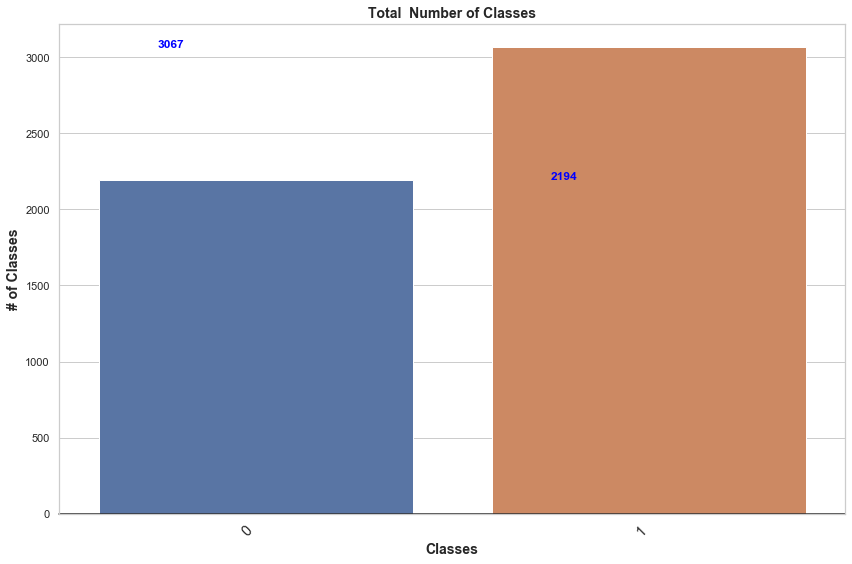

In [301]:
%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})
draw_col_shape(df_prediction,var_to_predict)

Random over-sampling:
1    3067
0    3067
Name: use_road_side, dtype: int64


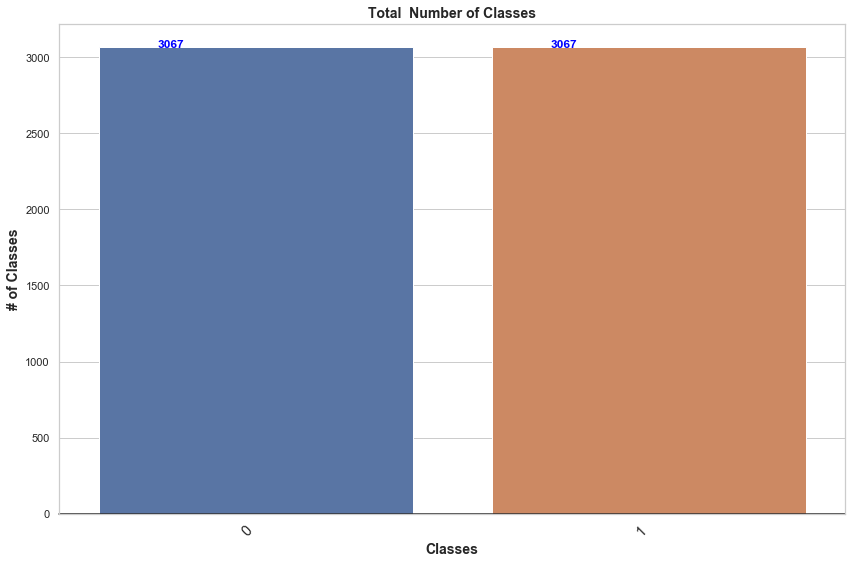

In [302]:
# Balance class Up Sampling
# As there is only 28 members that are using the Deposit Service.
# Will upsample the 11 (yes) to 5233
# Evaluate imbalanced classification model with different metrics

np.random.seed(42)
# Class count
count_class_1, count_class_0 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]


df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_test_over = pd.concat([df_class_0_over, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over[var_to_predict[0]].value_counts())

draw_col_shape(df_test_over,var_to_predict)
plt.show()

Random down-sampling:
1    2194
0    2194
Name: use_road_side, dtype: int64


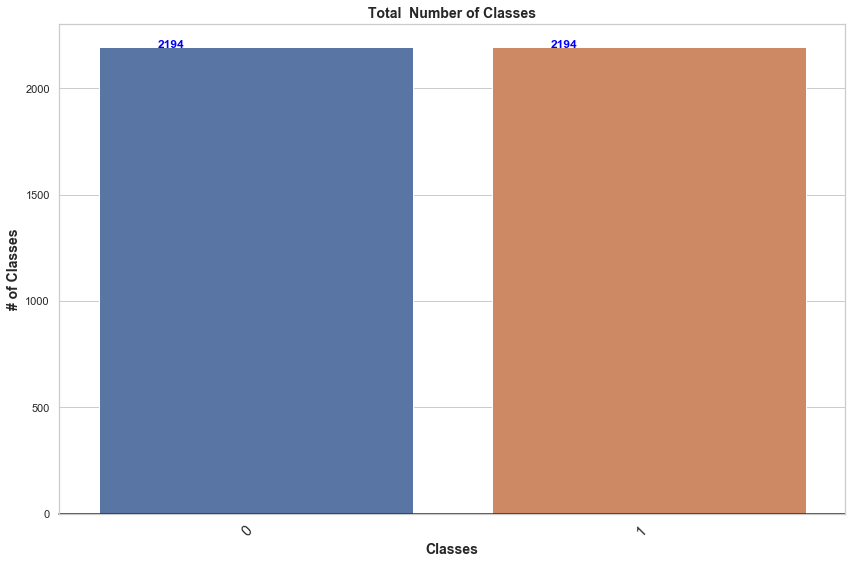

In [303]:
# Down sample Majority Class To Match Minority Class
# Indicies of each class' observations

np.random.seed(42)
count_class_1, count_class_0 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]

df_class_1_down = df_class_1.sample(count_class_0, replace=True)
df_test_down = pd.concat([df_class_0, df_class_1_down], axis=0)

print('Random down-sampling:')
print(df_test_down[var_to_predict[0]].value_counts())

draw_col_shape(df_test_down,var_to_predict)
plt.show()

In [304]:
df_test_over.corr()

,mean_total_calls_veh,consumer_score,mean_total_cost_veh,mean_total_member_cost_veh,income_100k_,income_40___99999,income_under_39999,aaa_financial_service_0,aaa_financial_service_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_alfa_romeo,sc_vehicle_manufacturer_name_ferrari,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel_0,aaa_travel_1,gender_female,gender_male,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,education_completed_college,education_high_school,education_some_college,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,use_road_side
mean_total_calls_veh,1.0000,0.8525,0.9839,0.9975,0.1331,0.1564,0.0789,-0.0755,0.0755,0.6295,0.5109,0.0246,0.1244,-0.0756,0.0756,0.0970,0.0656,0.0889,0.1335,-0.0133,-0.0036,0.3099,0.2298,0.7809,-0.0483,-0.0153,0.0704,-0.0961,0.0961,0.0594,-0.0858,-0.0263,0.0310,0.0896,-0.0891,0.0891,0.1314,0.1599,0.0225,0.0472,0.0111,-0.0013,-0.0028,0.0970,0.1057,0.1192,0.0090,-0.0075,0.0602,0.0067,0.4759
consumer_score,0.8525,1.0000,0.8960,0.8408,0.1153,0.1677,0.0795,-0.0714,0.0714,0.5841,0.4560,0.0243,0.1215,-0.0739,0.0739,0.0673,0.0692,0.1006,0.1273,-0.0107,-0.0107,0.1586,-0.0001,0.8545,-0.0359,-0.0181,0.0583,-0.0869,0.0869,0.0606,-0.0701,-0.0335,0.0307,0.0758,-0.0969,0.0969,0.1458,0.1281,0.0210,0.0609,-0.0014,-0.0205,-0.0033,0.1022,0.0963,0.1270,0.0220,-0.0191,0.0537,0.0087,0.4317
mean_total_cost_veh,0.9839,0.8960,1.0000,0.9810,0.1357,0.1632,0.0797,-0.0763,0.0763,0.6404,0.5135,0.0234,0.1287,-0.0769,0.0769,0.0930,0.0715,0.0950,0.1326,0.0005,0.0186,0.2839,0.2017,0.8163,-0.0466,-0.0148,0.0678,-0.0968,0.0968,0.0610,-0.0864,-0.0288,0.0354,0.0875,-0.0883,0.0883,0.1426,0.1515,0.0223,0.0508,0.0069,-0.0045,-0.0028,0.0983,0.1088,0.1236,0.0125,-0.0105,0.0577,0.0092,0.4804
mean_total_member_cost_veh,0.9975,0.8408,0.9810,1.0000,0.1331,0.1545,0.0791,-0.0756,0.0756,0.6242,0.5105,0.0250,0.1231,-0.0751,0.0751,0.0968,0.0645,0.0869,0.1325,-0.0131,0.0068,0.3185,0.2470,0.7645,-0.0502,-0.0136,0.0710,-0.0966,0.0966,0.0620,-0.0876,-0.0267,0.0317,0.0898,-0.0872,0.0872,0.1286,0.1597,0.0252,0.0433,0.0111,0.0003,-0.0027,0.0963,0.1054,0.1175,0.0079,-0.0071,0.0591,0.0081,0.4756
income_100k_,0.1331,0.1153,0.1357,0.1331,1.0000,-0.2594,-0.1562,-0.1069,0.1069,0.0656,0.0813,-0.0101,0.0536,-0.0650,0.0650,0.1470,0.0259,0.2024,0.0854,-0.0058,-0.0058,0.1117,0.0099,0.0802,-0.0176,0.0232,-0.0002,-0.0386,0.0386,0.0516,-0.1380,-0.0003,0.0828,0.0687,-0.0972,0.0972,0.1454,0.2165,0.1253,-0.0117,-0.0115,0.1319,-0.0836,0.2487,0.1149,0.1817,-0.0225,-0.0487,0.1974,-0.0915,0.1155
income_40___99999,0.1564,0.1677,0.1632,0.1545,-0.2594,1.0000,-0.1935,-0.0003,0.0003,0.1093,0.0848,0.0218,0.0084,-0.0566,0.0566,0.0547,0.0184,0.0671,0.1841,-0.0072,0.0225,0.0011,0.0224,0.1607,0.0268,-0.0404,0.0048,-0.0731,0.0731,-0.0206,-0.0113,0.0237,-0.0074,0.0057,-0.0828,0.0828,0.1481,0.1241,-0.0453,0.1655,0.0088,-0.0392,-0.0329,0.1053,0.2302,0.2059,-0.0184,0.0080,0.0815,-0.0127,0.1072
income_under_39999,0.0789,0.0795,0.0797,0.0791,-0.1562,-0.1935,1.0000,0.0107,-0.0107,0.0827,0.0171,-0.0075,-0.0173,-0.0198,0.0198,-0.0025,0.0340,-0.0323,0.1194,-0.0044,-0.0044,-0.0336,0.0160,0.0947,0.04

In [305]:
df_test_down.describe()

,mean_total_calls_veh,consumer_score,mean_total_cost_veh,mean_total_member_cost_veh,income_100k_,income_40___99999,income_under_39999,aaa_financial_service_0,aaa_financial_service_1,plus_indicator_description_basic_membership,plus_indicator_description_plus_membership,plus_indicator_description_plus_membership_with_motorcycle_coverage,plus_indicator_description_premier_membership,aaa_credit_card_0,aaa_credit_card_1,occupation_group_management,occupation_group_other,occupation_group_professional,occupation_group_retired,sc_vehicle_manufacturer_name_alfa_romeo,sc_vehicle_manufacturer_name_ferrari,sc_vehicle_manufacturer_name_luxury_vehicle,sc_vehicle_manufacturer_name_middle_end_vehicle,sc_vehicle_manufacturer_name_standard_end_vehicle,tenure__40_years,tenure_between_21___40_years,tenure_under_20_years,aaa_auto_insurance_0,aaa_auto_insurance_1,no_members__5___member,no_members_1___member,no_members_2___member,no_members_3___member,no_members_4___member,aaa_travel_0,aaa_travel_1,gender_female,gender_male,kcl_b_ind_mosaicsgrouping_boomers,kcl_b_ind_mosaicsgrouping_golden_year,kcl_b_ind_mosaicsgrouping_middle_class_melting_pot,kcl_b_ind_mosaicsgrouping_power_elite,kcl_b_ind_mosaicsgrouping_singles_and_starters,education_completed_college,education_high_school,education_some_college,dwelling_type_large_multi_family_w_o_apt_number,dwelling_type_p_o__box,dwelling_type_sfdu,dwelling_type_small_or_large_multi_family_w_apt_number,use_road_side
count,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000,4388.0000
mean,1.3755,28.1269,21.7700,73.1311,0.1675,0.2575,0.0987,0.9332,0.0668,0.2614,0.1869,0.0005,0.0134,0.8952,0.1048,0.0725,0.0182,0.1142,0.1579,0.0002,0.0000,0.0670,0.0358,0.3585,0.6108,0.1616,0.2277,0.7368,0.2632,0.0611,0.3038,0.3655,0.1698,0.0998,0.8667,0.1333,0.2131,0.1493,0.2242,0.2495,0.0713,0.0898,0.0700,0.0827,0.1372,0.1404,0.0039,0.0146,0.5777,0.1089,0.5000
std,1.3295,33.7341,23.5721,71.6247,0.3735,0.4373,0.2983,0.2497,0.2497,0.4394,0.3899,0.0213,0.1152,0.3064,0.3064,0.2593,0.1338,0.3181,0.3647,0.0151,0.0000,0.2501,0.1858,0.4796,0.4876,0.3681,0.4194,0.4404,0.4404,0.2395,0.4599,0.4816,0.3755,0.2998,0.3400,0.3400,0.4095,0.3564,0.4171,0.4328,0.2574,0.2859,0.2551,0.2755,0.3441,0.3474,0.0621,0.1199,0.4940,0.3116,0.5001
min,0.0000,0.0000,0.0072,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.1645,0.0000,0.0072,8.4416,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.1645,0.0000,0.0072,8.4416,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.5000
75%,2.6063,65.0000,47.0448,144.3258,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.00

# Setting Up the Training and Test data for up Sampling the minority class
To use the same split in all models

In [312]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.3

# Create input and output dataframes
#X_df = pd.DataFrame(df_prediction,columns=X_cols)
#y_df = pd.DataFrame(df_prediction,columns=y_cols)

X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

# Algorithms Search and Testing

Roadside Services - Algorithm Comparison - Over Sampling
LR: Accuracy : 0.744011 - Std. Dev.: (0.017430)
LDA: Accuracy : 0.744714 - Std. Dev.: (0.019687)
KNN: Accuracy : 0.703706 - Std. Dev.: (0.010384)
CART: Accuracy : 0.765424 - Std. Dev.: (0.014976)
NB: Accuracy : 0.621717 - Std. Dev.: (0.031937)
SVM: Accuracy : 0.739822 - Std. Dev.: (0.019065)
SGD: Accuracy : 0.737713 - Std. Dev.: (0.011963)
AB: Accuracy : 0.738649 - Std. Dev.: (0.014579)
GBM: Accuracy : 0.748902 - Std. Dev.: (0.018872)
RF: Accuracy : 0.789877 - Std. Dev.: (0.015579)
ET: Accuracy : 0.808290 - Std. Dev.: (0.016144)
XGB: Accuracy : 0.747968 - Std. Dev.: (0.016535)


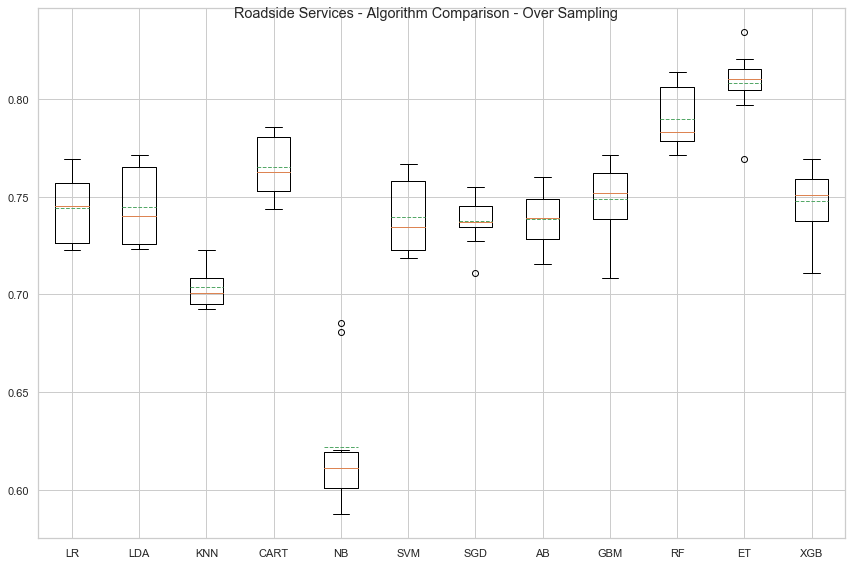

In [313]:
# Algorithms Search
# Spot Check Algorithms

print(var_to_predict_title+' - Algorithm Comparison - Over Sampling')
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(loss='log')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
ensembles.append(('XGB', XGBClassifier()))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison - Over Sampling')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig(var_to_predict_save+'_algorithms')
plt.show()

# Setting Up the Training and Test data for Down Sampling the mayority class
To use the same split in all models

In [310]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.3

# Create input and output dataframes
X_df = pd.DataFrame(df_test_down,columns=X_cols)
y_df = pd.DataFrame(df_test_down,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

Roadside Services - Algorithm Comparison - Down Sampling
LR: Accuracy : 0.736569 - Std. Dev.: (0.020508)
LDA: Accuracy : 0.732334 - Std. Dev.: (0.018477)
KNN: Accuracy : 0.692597 - Std. Dev.: (0.028623)
CART: Accuracy : 0.713780 - Std. Dev.: (0.024706)
NB: Accuracy : 0.675685 - Std. Dev.: (0.030693)
SVM: Accuracy : 0.730385 - Std. Dev.: (0.025758)
SGD: Accuracy : 0.721590 - Std. Dev.: (0.025971)
AB: Accuracy : 0.730056 - Std. Dev.: (0.021517)
GBM: Accuracy : 0.741452 - Std. Dev.: (0.024259)
RF: Accuracy : 0.745038 - Std. Dev.: (0.023221)
ET: Accuracy : 0.735278 - Std. Dev.: (0.025422)
XGB: Accuracy : 0.743733 - Std. Dev.: (0.019800)


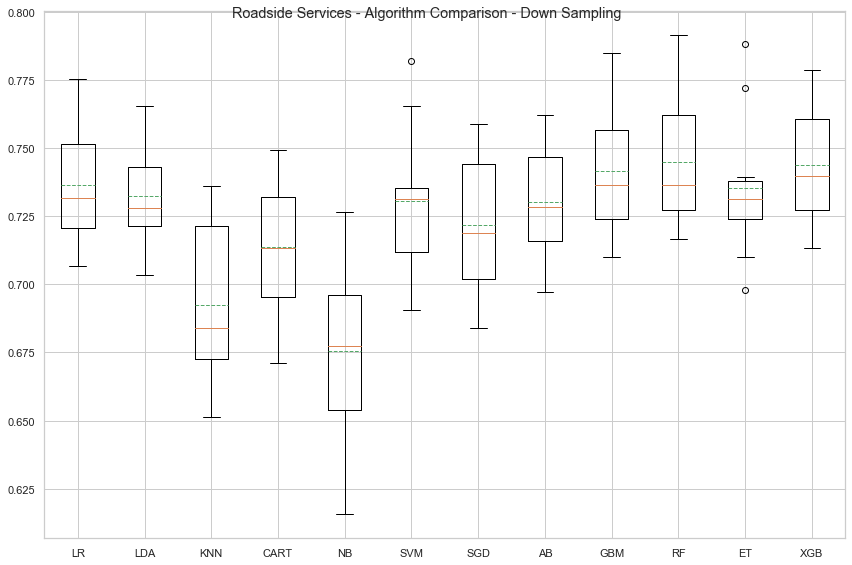

In [311]:
# Spot Check Algorithms
print(var_to_predict_title+' - Algorithm Comparison - Down Sampling')
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('SGD', SGDClassifier(loss='log')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
ensembles.append(('XGB', XGBClassifier()))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy : %f - Std. Dev.: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle(var_to_predict_title+' - Algorithm Comparison - Down Sampling')
ax = fig.add_subplot(111)
plt.boxplot(results, meanline=True, showmeans=True)
ax.set_xticklabels(names)
plt.savefig(var_to_predict_save+'_algorithms_down')
plt.show()

# Observation
Based on the previous graph, the model performs better by up sampling the minority class.  the rest of the analysis will be performed using the up sampling data.

In [245]:
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'
test_size = 0.5

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

# Grid Search Logistic Regression

In [246]:
# Grid Search with Up Sampling
# Logistic regression
np.random.seed(42)
logregpipe = Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                   ('logreg',LogisticRegression(penalty='l2',multi_class="auto"))])
# Grid search to determine the value of C and solver
param_grid = {'logreg__C':np.arange(0.01,100,10), 'logreg__solver':['lbfgs','liblinear','newton-cg']}
logreg_cv = GridSearchCV(logregpipe,param_grid,cv=num_folds,return_train_score=True, scoring=scoring)
logreg_cv.fit(trainX, trainy)
print('Logistic regression - Over Sampling the minority class')
print('Logistic Regression - Best Parameters       : ', logreg_cv.best_params_)

bestlogreg = logreg_cv.best_estimator_
bestlogreg.fit(trainX,trainy)
bestlogreg.coef_ = bestlogreg.named_steps['logreg'].coef_
print('Logistic Regression - Accuracy Training Data : %.3f' % bestlogreg.score(trainX,trainy))
print('Logistic Regression - Accuracy Test Data     : %.3f' % bestlogreg.score(testX,testy))

Logistic regression - Over Sampling the minority class
Logistic Regression - Best Parameters       :  {'logreg__C': 60.01, 'logreg__solver': 'liblinear'}
Logistic Regression - Accuracy Training Data : 0.762
Logistic Regression - Accuracy Test Data     : 0.741


# Observation
These are the best parameters:

First run identifying C
    * Logistic regression - Over Sampling the minority class
    * Logistic Regression - Best Parameters       :  {'logreg__C': 40.01, 'logreg__solver': 'lbfgs'}
    * Logistic Regression - Accuracy Training Data : 0.693
    * Logistic Regression - Accuracy Test Data     : 0.661
    
Narrowing the C paramenters to find the best having incremental of 1 instead of 10 around the best found previously
    * Logistic regression - Over Sampling the minority class
    * Logistic Regression - Best Parameters       :  {'logreg__C': 45, 'logreg__solver': 'lbfgs'}
    * Logistic Regression - Accuracy Training Data : 0.690
    * Logistic Regression - Accuracy Test Data     : 0.659


In [ ]:
# Use Logistic Regression algorithms to classify which customers are going to use Deposit Service or not (0 = No, 1 = Yes)
# Using Oversample Dataframe with transformation MinMax Scaler

np.random.seed(42)
# Define model 
lr = LogisticRegression(penalty='l2',multi_class="multinomial", solver="lbfgs", C=45)

# Fit model
lr.fit(trainX, trainy)

# Predict on test set
yhat = lr.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = lr.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
lr_scores = cross_val_score(lr, testX, testy, cv=num_folds)

# Evaluate predictions
print('Logistic Regression - Accuracy training          : %.3f' % accuracy_score(lr.predict(trainX), trainy))
print('Logistic Regression - Accuracy test              : %.3f' % accuracy_score(testy, yhat))
print('Logistic Regression - Precision                  : %.3f' % precision_score(testy, yhat))
print('Logistic Regression - Recall                     : %.3f' % recall_score(testy, yhat))
print('Logistic Regression - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Logistic Regression - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Logistic Regression - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Logistic Regression - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Logistic Regression - ROC AUC                    : %.3f' % (lr_auc))
print('Logistic Regression - Cross Validation Accuracy  : %0.3f (+/- %0.3f)' % (lr_scores.mean(), lr_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Show title
plt.title('Logistic Regression - ROC Curve - '+var_to_predict_title, loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_lr_roc')
plt.show()

In [ ]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Logistic Regression", None),
                  ("Normalized confusion matrix - "+var_to_predict_title + " - Logistic Regression", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_lr_cm')
    else: plt.savefig(var_to_predict_save+'_lr_cm_1')
    i +=1
    plt.show()

In [ ]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': lr.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts_df_lgr = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts_df_lgr.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_df_lgr, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_lr_coef.png')
py.iplot(fig)

In [ ]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Logistic Regression Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_df_lgr['Features (MinMax Transformer)'], x=counts_df_lgr['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_lr_coef_1')
plt.show()

# k-Nearest Neighbors

In [ ]:
# KNN Model - Grid search with RandomizedSearch
np.random.seed(42)
num_folds = 10
scoring='accuracy'
weight_options = ['uniform', 'distance']
algorithm_options = ['ball_tree', 'kd_tree', 'brute']
neighbors_settings = list(range(1, 10))
leaf_options = list(range(1, 50))
param_grid = dict(n_neighbors=neighbors_settings, weights=weight_options, algorithm=algorithm_options, leaf_size=leaf_options)

knn = KNeighborsClassifier()
best_scores = []
for _ in range(10):
    rand = RandomizedSearchCV(knn, param_grid, cv=num_folds, scoring=scoring, n_iter=10)
    rand.fit(trainX,trainy)
    best_scores.append([rand.best_params_,rand.best_score_])

for i in range(len(best_scores)):
    print('The best parameters : ',best_scores[i])

In [ ]:
# KNN Model - Grid search
# The best parameters :
    # :  The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 38, 'algorithm': 'brute'}, 0.9631941419213803]
np.random.seed(42)

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 20
neighbors_settings = range(1, 10)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors,  weights='distance', leaf_size=38, algorithm='brute')
    knn.fit(trainX, trainy)
    # record training set accuracy
    training_accuracy.append(knn.score(trainX, trainy))
    # record test set accuracy
    test_accuracy.append(knn.score(testX, testy))

plt.plot(neighbors_settings, training_accuracy, label="Training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
# Show title
plt.title('KNN Neighbors Grid Search - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.savefig(var_to_predict_save+'_knn_compare_model')

# Observations
The plot shows the training and test set accuracy on the y-axis against the setting of n_neighbors on the x-axis. Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the training accuracy drops, indicating that using more than 2 neighbor leads to a model that is too complex.

The best performance is somewhere around 2 neighbors. Still, it is good to keep the scale of the plot in mind. The worst performance is more than 82% accuracy, which might still be pretty good.

The above plot suggests that we should choose n_neighbors= where the model gets its stability. 
Outcome of the Grid Search above 
* The best parameters : The best parameters :  [{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 38, 'algorithm': 'brute'}, 0.9631941419213803]
    

In [ ]:
# Best model
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', leaf_size=38, algorithm='brute')
knn.fit(trainX, trainy)


print('Accuracy of K-NN classifier on training set: {:.3f}'.format(knn.score(trainX, trainy)))
print('Accuracy of K-NN classifier on test set: {:.3f}'.format(knn.score(testX, testy)))

# Predict on test set
yhat = knn.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
knn_probs = knn.predict_proba(testX)

# Keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
knn_auc = roc_auc_score(testy, knn_probs)

# Calculate Cross valdation scores
knn_scores = cross_val_score(knn, testX, testy, cv=num_folds)

# Evaluate predictions
print('K-NN classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('K-NN classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('K-NN classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('K-NN classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('K-NN Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('K-NN classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('K-NN classifier - ROC AUC                    : %.3f' % (knn_auc))
print("K-NN classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (knn_scores.mean(), knn_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(testy, knn_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# Show title
plt.title('KNN Classiffier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_knn_roc')
plt.show()

In [ ]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - KNN Classiffier", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - KNN Classiffier", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_knn_cm')
    else: plt.savefig(var_to_predict_save+'_knn_cm_1')
    i +=1
    plt.show()

# CART  Model - DecisionTreeClassifier

In [ ]:
# DecisionTreeClasifier
np.random.seed(42)

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(100, 125,1)}

# decision tree model
cart = DecisionTreeClassifier()

#use gridsearch to test all values
cart_gscv = GridSearchCV(cart, param_grid, cv=num_folds)

#fit model to data
cart_gscv.fit(trainX, trainy)
print('Best parameters : ', cart_gscv.best_params_)
print('Best Score      : ', cart_gscv.best_score_)

# Observation

Based on the grid search above, the best parameter for the Decission Tree Classifier is:
* The 1st run showed 
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 112}
    * Best Score      :  0.9504566228129233
    * As I am using an increment of 10, rerun it, using increment of 1 from +-10

* Narrowing the parameters
    * Best parameters :  {'criterion': 'entropy', 'max_depth': 122}
    * Best Score      :  0.9506518656982408

In [ ]:
# Modeling based on the outcome of the grid serach
cart = DecisionTreeClassifier(criterion = 'entropy', max_depth=122)
cart.fit(trainX, trainy)

# Predict on test set
yhat = cart.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
cart_probs = cart.predict_proba(testX)

# Keep probabilities for the positive outcome only
cart_probs = cart_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
cart_auc = roc_auc_score(testy, cart_probs)

# Calculate Cross valdation scores
cart_scores = cross_val_score(cart, testX, testy, cv=num_folds)

print("CART - Accuracy on training set: {:.3f}".format(cart.score(trainX, trainy)))
print("CART - Accuracy on test set: {:.3f}".format(cart.score(testX, testy)))

# Evaluate predictions
print('CART - Precision                  : %.3f' % precision_score(testy, yhat))
print('CART - Recall                     : %.3f' % recall_score(testy, yhat))
print('CART - F-measure                  : %.3f' % f1_score(testy, yhat))
print('CART - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('CART - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('CART - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('CART - ROC AUC                    : %.3f' % (cart_auc))
print("CART - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (cart_scores.mean(), cart_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
cart_fpr, cart_tpr, _ = roc_curve(testy, cart_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(cart_fpr, cart_tpr, marker='.', label='CART - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('CART Classiffier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_cart_roc')
# show the plot
plt.show()

In [ ]:
# Confusion Metrics
np.set_printoptions(precision=2)

i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - CART", None),
                  ("CART - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(cart, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

    if i==1: plt.savefig(var_to_predict_save+'_cart_cm')
    else: plt.savefig(var_to_predict_save+'_cart_cm_1')
    i +=1
    plt.show()

# Feature importance in trees
feature importance rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [ ]:
coef_df_cart = pd.DataFrame({'feature':testX.columns, 'coefs': cart.feature_importances_})
coef_df_cart["abs_coeff"] = coef_df_cart['coefs'].abs()
coef_df_cart.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_cart.nlargest(30,columns=["abs_coeff"])
counts_cart = pd.DataFrame(coef_df_cart.nlargest(30,columns=["abs_coeff"]), index=None)
counts_cart.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_cart, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_cart_coef.png')
py.iplot(fig)

In [ ]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of CART Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_cart['Features (MinMax Transformer)'], x=counts_cart['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_cart_coef_1')
plt.show()

# Random Forest Classifier Model

In [ ]:
np.random.seed(42)
num_folds = 10
scoring = 'accuracy'
#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 125, 10)}

# Random Forest Classifier model
rf = RandomForestClassifier()

#use gridsearch to test all values
rf_gscv = GridSearchCV(rf, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
rf_gscv.fit(trainX, trainy)
print('Best parameters : ', rf_gscv.best_params_)
print('Best score      : ', rf_gscv.best_score_)

# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run showed a max_depth of 112, with gini, as I am using an increment of 10, rerun it, using increment of 1 from +-10
    * Best parameters :  {'criterion': 'gini', 'max_depth': 62}
    * Best score      :  0.9960191044965268
* Narrowing the search around the best parameter of the 1st search
    * Best parameters :  {'criterion': 'gini', 'max_depth': 62}
    * Best score      :  0.9960191044965268

In [ ]:
# Modeling based on the outcome of the grid serach of the random forest
rf = DecisionTreeClassifier(criterion = 'gini', max_depth=62)
rf.fit(trainX, trainy)

# Predict on test set
yhat = rf.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
rf_probs = rf.predict_proba(testX)

# Keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
rf_auc = roc_auc_score(testy, rf_probs)

# Calculate Cross valdation scores
rf_scores = cross_val_score(rf, testX, testy, cv=num_folds)

print("Random Forest - Accuracy on training set: {:.3f}".format(rf.score(trainX, trainy)))
print("Random Forest - Accuracy on test set: {:.3f}".format(rf.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Random Forest - Precision                  : %.3f' % precision_score(testy, yhat))
print('Random Forest - Recall                     : %.3f' % recall_score(testy, yhat))
print('Random Forest - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Random Forest - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Random Forest - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Random Forest - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Random Forest - ROC AUC                    : %.3f' % (rf_auc))
print("Random Forest - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (rf_scores.mean(), rf_scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(testy, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Random Forest - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_rf_roc')
plt.show()

In [ ]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1 
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+ ", without normalization - Random Forest", None),
                  ("Normalized confusion matrix - "+var_to_predict_title+" - Random Forest", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_rf_cm')
    else: plt.savefig(var_to_predict_save+'_rf_cm_1')
    i +=1
    plt.show()

# Feature importance
feature importance rates how important each feature is for the random forest tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [ ]:
coef_df_rf = pd.DataFrame({'feature':testX.columns, 'coefs': rf.feature_importances_})
coef_df_rf["abs_coeff"] = coef_df_rf['coefs'].abs()
coef_df_rf.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_rf.nlargest(30,columns=["abs_coeff"])
counts_rf = pd.DataFrame(coef_df_rf.nlargest(30,columns=["abs_coeff"]), index=None)
counts_rf.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_rf, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_rf_coef.png')
py.iplot(fig)

In [ ]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Random Forest Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_rf['Features (MinMax Transformer)'], x=counts_rf['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_rf_coef_1')
plt.show()

# ExtraTreesClassifier Classifier

In [315]:
np.random.seed(42)
#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(60, 85,1)}

# Random Forest Classifier model
et = ExtraTreesClassifier()

#use gridsearch to test all values
et_gscv = GridSearchCV(et, param_grid, cv=num_folds, scoring=scoring)

#fit model to data
et_gscv.fit(trainX, trainy)
print('Best parameters : ', et_gscv.best_params_)
print('Best score      : ', et_gscv.best_score_)

Best parameters :  {'criterion': 'entropy', 'max_depth': 84}
Best score      :  0.8234254892394427


# Observation
Based on the grid search above, th best parameter for the Random Forest Classifier is:
* The 1st run showed a max_depth of 32, with gini, as I am using an increment of 10, rerun it, using increment of 1 from +-10
    * Best parameters :  {'criterion': 'gini', 'max_depth': 62}
    * Best score      :  0.9964179069012221
* Narrowing the search around the best parameter of the 1st search
    * Best parameters :  {'criterion': 'gini', 'max_depth': 62}
    * Best score      :  0.9964179069012221

In [323]:
testX.shape

(1841, 50)

Extra Tree Classifier - Accuracy on training set: 0.948
Extra Tree Classifier - Accuracy on test set: 0.837
Extra Tree Classifier - Precision                  : 0.859
Extra Tree Classifier - Recall                     : 0.794
Extra Tree Classifier - F-measure                  : 0.825
Extra Tree Classifier - Log-Loss                   : 5.647
Extra Tree Classifier - Cross Entropy Loss         : 1.151
Extra Tree Classifier - No Skill - ROC AUC         : 0.500
Extra Tree Classifier - ROC AUC                    : 0.893
Extra Tree Classifier - Cross Validation Accuracy  : 0.763 (+/- 0.063)


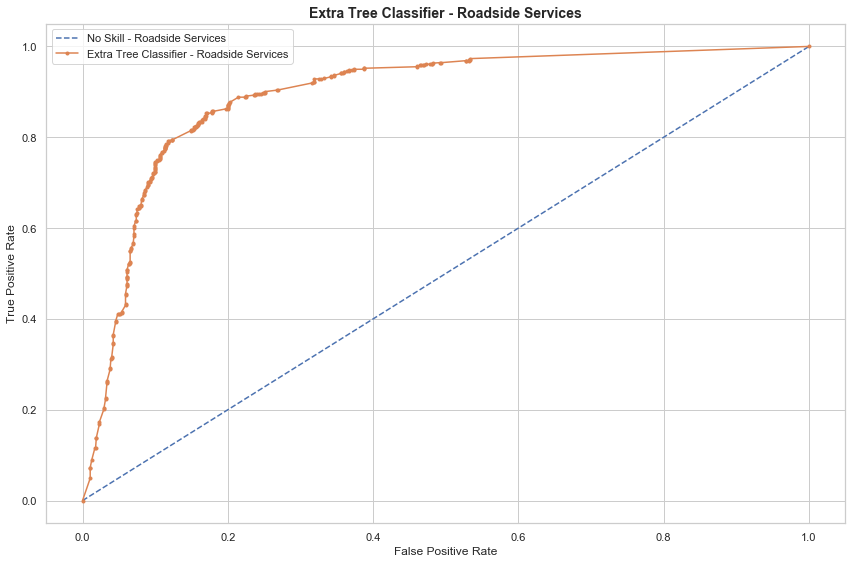

In [316]:
# Modeling based on the outcome of the grid serach of the random forest
et = ExtraTreesClassifier(criterion = 'entropy', max_depth=84)
et.fit(trainX, trainy)

# Predict on test set
yhat = et.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
et_probs = et.predict_proba(testX)

# Keep probabilities for the positive outcome only
et_probs = et_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
et_auc = roc_auc_score(testy, et_probs)

# Calculate Cross valdation scores
scores_et = cross_val_score(et, testX, testy, cv=num_folds)

print("Extra Tree Classifier - Accuracy on training set: {:.3f}".format(et.score(trainX, trainy)))
print("Extra Tree Classifier - Accuracy on test set: {:.3f}".format(et.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Extra Tree Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('Extra Tree Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('Extra Tree Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('Extra Tree Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('Extra Tree Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('Extra Tree Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Extra Tree Classifier - ROC AUC                    : %.3f' % (et_auc))
print("Extra Tree Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_et.mean(), scores_et.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
et_fpr, et_tpr, _ = roc_curve(testy, et_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(et_fpr, et_tpr, marker='.', label='Extra Tree Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_et_roc')
plt.show()

Confusion matrix - Roadside Services, without normalization - Extra Tree Classifier
[[829 117]
 [184 711]]


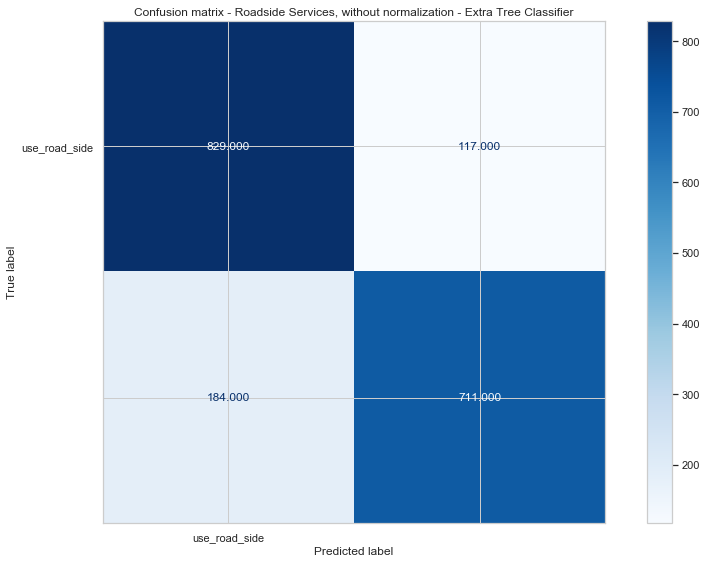

Extra Tree Classifier - Normalized confusion matrix - Roadside Services
[[0.88 0.12]
 [0.21 0.79]]


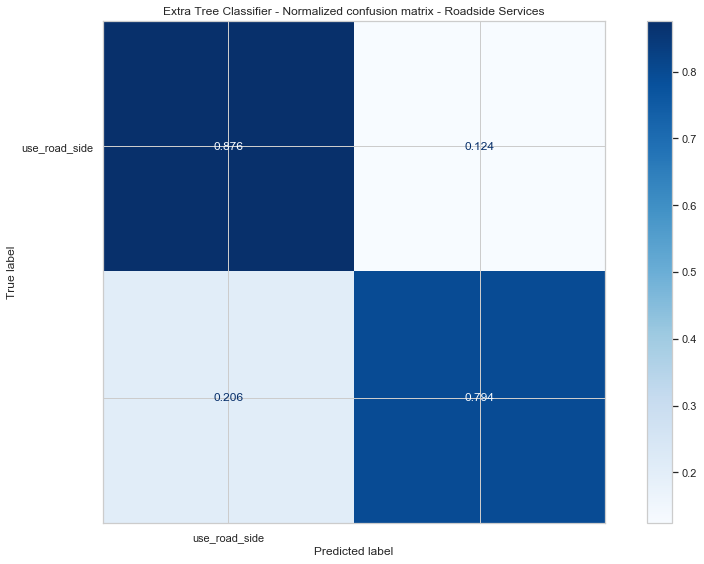

In [317]:
# Confusion Metrics
np.set_printoptions(precision=2)
i = 1
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - "+var_to_predict_title+", without normalization - Extra Tree Classifier", None),
                  ("Extra Tree Classifier - Normalized confusion matrix - "+var_to_predict_title, 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(et, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    if i==1: plt.savefig(var_to_predict_save+'_et_cm')
    else: plt.savefig(var_to_predict_save+'_et_cm_1')
    i +=1
    plt.show()

In [224]:
coef_df_et = pd.DataFrame({'feature':testX.columns, 'coefs': et.feature_importances_})
coef_df_et["abs_coeff"] = coef_df_et['coefs'].abs()
coef_df_et.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_et.nlargest(30,columns=["abs_coeff"])
counts_et = pd.DataFrame(coef_df_et.nlargest(30,columns=["abs_coeff"]), index=None)
counts_et.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_et, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_et_coef.png')
py.iplot(fig)

In [ ]:
df_cumsum = coef_df_et.copy()
df_cumsum.set_index('feature', inplace=True)
df_cumsum.abs_coeff.cumsum().plot(kind='barh', figsize=(12,10))
plt.xticks(
            rotation=90, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='small')
plt.show()

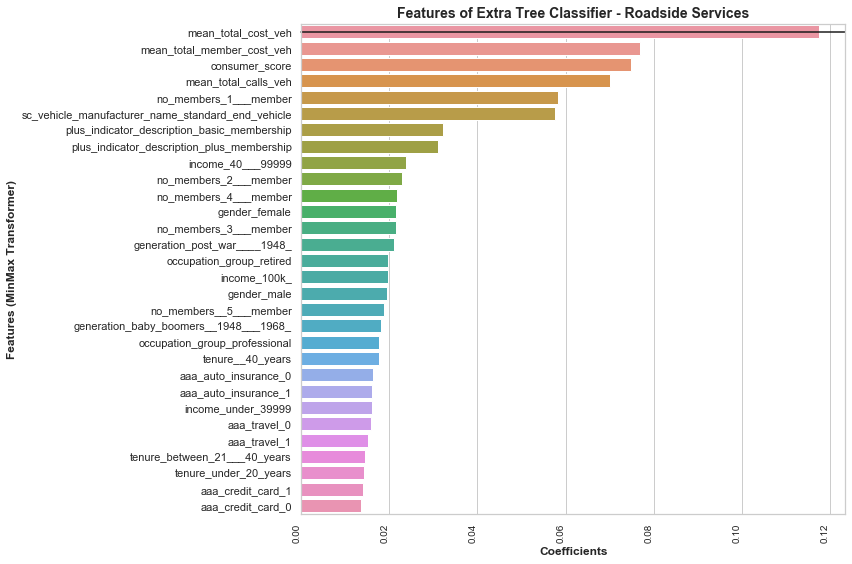

In [225]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of Extra Tree Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_et['Features (MinMax Transformer)'], x=counts_et['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_et_coef_1')
plt.show()

# XGBOOSTING Modeling

In [ ]:
np.random.seed(42)
scoring = 'accuracy'

#create a dictionary of all values we want to test
param_grid = {'max_depth': [5,6,7, 8], 'n_estimators': range(50, 250, 50), 
              'learning_rate': [0.1, 0.01, 0.05], 'min_child_weight':[2,4, 6],
              'gamma':[0.1]
             }
# CV model
xgb = XGBClassifier(objective= 'binary:logistic',nthread=4)
kfold = KFold(n_splits=num_folds)
xgb_gscv = GridSearchCV(estimator=xgb,param_grid=param_grid, scoring = scoring, 
                        n_jobs = 10, cv = kfold,verbose=True
                       )
xgb_gscv.fit(trainX, trainy)
print('Best parameters - : ', xgb_gscv.best_params_)
print('Best score      : ', xgb_gscv.best_score_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   27.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.7min


# Observation
Best parameters - :  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 200}
Best score      :  0.9773189547971137

In [ ]:
# Modeling based on the outcome of the grid serach of the random forest
xgb = xgb = XGBClassifier(objective= 'binary:logistic',nthread=4, gamma=0.1,
                          learning_rate=0.1, max_depth=8, min_child_weight=2,
                          n_estimators=200                        
                         )
xgb.fit(trainX, trainy)

# Predict on test set
yhat = xgb.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
xgb_probs = xgb.predict_proba(testX)

# Keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
xgb_auc = roc_auc_score(testy, xgb_probs)

# Calculate Cross valdation scores
scores_xgb = cross_val_score(xgb, testX, testy, cv=num_folds)

print("XGBoost Classifier - Accuracy on training set: {:.3f}".format(xgb.score(trainX, trainy)))
print("XGBoost Classifier - Accuracy on test set: {:.3f}".format(xgb.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('XGBoost Classifier - Precision                  : %.3f' % precision_score(testy, yhat))
print('XGBoost Classifier - Recall                     : %.3f' % recall_score(testy, yhat))
print('XGBoost Classifier - F-measure                  : %.3f' % f1_score(testy, yhat))
print('XGBoost Classifier - Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('XGBoost Classifier - Cross Entropy Loss         : %.3f' % cross_entropy(yhat, testy[var_to_predict[0]]))
print('XGBoost Classifier - No Skill - ROC AUC         : %.3f' % (ns_auc))
print('XGBoost Classifier - ROC AUC                    : %.3f' % (xgb_auc))
print("XGBoost Classifier - Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(testy, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - '+var_to_predict_title)
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost Classifier - '+var_to_predict_title)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
# show the plot
plt.savefig(var_to_predict_save+'_xgb_roc')
plt.show()

In [ ]:
coef_df_xgb = pd.DataFrame({'feature':testX.columns, 'coefs': xgb.feature_importances_})
coef_df_xgb["abs_coeff"] = coef_df_xgb['coefs'].abs()
coef_df_xgb.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_xgb.nlargest(30,columns=["abs_coeff"])
counts_xgb = pd.DataFrame(coef_df_xgb.nlargest(30,columns=["abs_coeff"]), index=None)
counts_xgb.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts_xgb, height_constant=30, index=False)
fig.write_image(var_to_predict_save+'_xgb_coef.png')
py.iplot(fig)

In [ ]:
# Bar graph of Coefficients
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.title('Features of XGBooster Classifier - '+var_to_predict_title,loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(y=counts_xgb['Features (MinMax Transformer)'], x=counts_xgb['Coefficients'], orient='h')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.savefig(var_to_predict_save+'_xgb_coef_1')
plt.show()

# Keras Modeling

In [227]:
# Keras Classifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


np.random.seed(42)
# Create input and output dataframes

num_folds = 10
scoring = 'accuracy'

# create model
keras_nn = Sequential()
keras_nn.add(Dense(trainX.shape[1], input_dim=trainX.shape[1], activation='relu'))
keras_nn.add(Dropout(0.2))
keras_nn.add(Dense(int(trainX.shape[1]/2), activation='relu'))
keras_nn.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.01, momentum=0.8)
keras_nn.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[scoring])
# Fit the model
history = keras_nn.fit(trainX, trainy, validation_data=(testX,testy), epochs=150, batch_size=10, verbose=1)
# evaluate the model
scores = keras_nn.evaluate(trainX, trainy, verbose=0)
print("Keras - Accuracy Train Set : %.3f" % scores[1])
scores = keras_nn.evaluate(testX, testy, verbose=0)
print("Keras - Accuracy Test Set  : %.3f" % scores[1])

Using TensorFlow backend.


Train on 2630 samples, validate on 2631 samples
Epoch 1/150
2630/2630 [==============================] - 1s 413us/step - loss: 0.5944 - accuracy: 0.6875 - val_loss: 0.5619 - val_accuracy: 0.7260
Epoch 2/150
2630/2630 [==============================] - 1s 265us/step - loss: 0.5445 - accuracy: 0.7361 - val_loss: 0.5542 - val_accuracy: 0.7305
Epoch 3/150
2630/2630 [==============================] - 1s 372us/step - loss: 0.5348 - accuracy: 0.7449 - val_loss: 0.5499 - val_accuracy: 0.7385
Epoch 4/150
2630/2630 [==============================] - 1s 262us/step - loss: 0.5286 - accuracy: 0.7532 - val_loss: 0.5406 - val_accuracy: 0.7408
Epoch 5/150
2630/2630 [==============================] - 1s 254us/step - loss: 0.5206 - accuracy: 0.7616 - val_loss: 0.5435 - val_accuracy: 0.7393
Epoch 6/150
2630/2630 [==============================] - 1s 266us/step - loss: 0.5175 - accuracy: 0.7620 - val_loss: 0.5364 - val_accuracy: 0.7450
Epoch 7/150
2630/2630 [==============================] - 1s 325us/step

2630/2630 [==============================] - 1s 246us/step - loss: 0.4110 - accuracy: 0.8167 - val_loss: 0.6310 - val_accuracy: 0.7241
Epoch 112/150
2630/2630 [==============================] - 1s 233us/step - loss: 0.3962 - accuracy: 0.8183 - val_loss: 0.6346 - val_accuracy: 0.7237
Epoch 113/150
2630/2630 [==============================] - 1s 290us/step - loss: 0.4042 - accuracy: 0.8171 - val_loss: 0.6519 - val_accuracy: 0.7282
Epoch 114/150
2630/2630 [==============================] - 1s 344us/step - loss: 0.4041 - accuracy: 0.8194 - val_loss: 0.6387 - val_accuracy: 0.7130
Epoch 115/150
2630/2630 [==============================] - 1s 238us/step - loss: 0.4105 - accuracy: 0.8065 - val_loss: 0.6343 - val_accuracy: 0.7199
Epoch 116/150
2630/2630 [==============================] - 1s 242us/step - loss: 0.4100 - accuracy: 0.8110 - val_loss: 0.6386 - val_accuracy: 0.7275
Epoch 117/150
2630/2630 [==============================] - 1s 235us/step - loss: 0.4080 - accuracy: 0.8171 - val_loss: 0

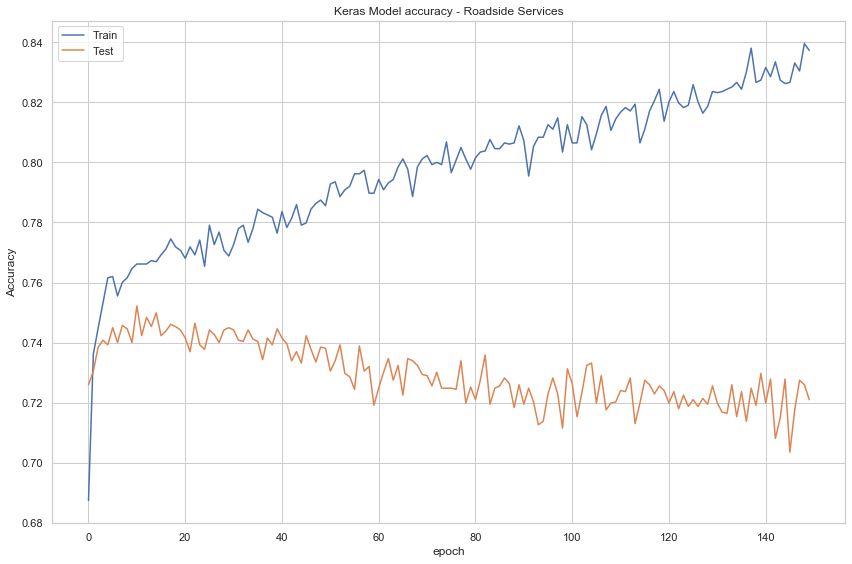

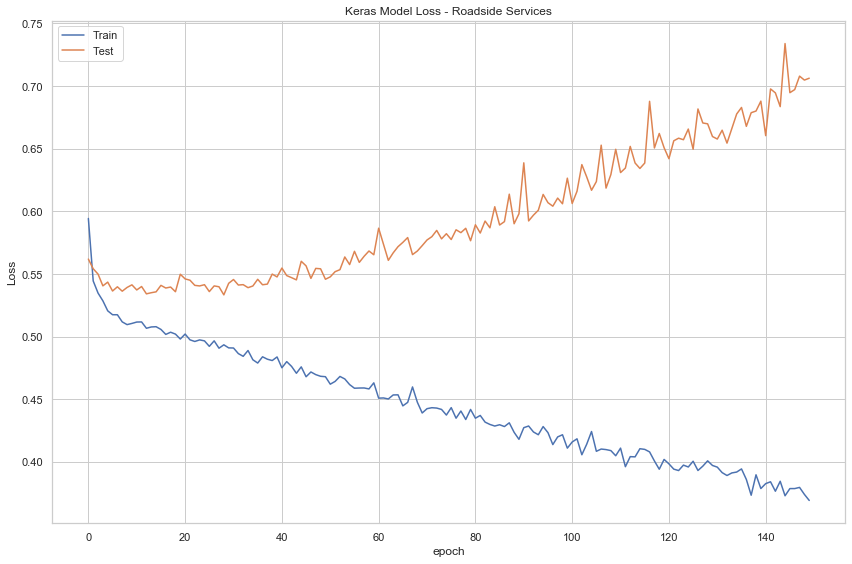

In [228]:
# Visualize training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Keras Model accuracy - '+var_to_predict_title )
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(var_to_predict_save+'_keras_model_1')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras Model Loss - '+ var_to_predict_title)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(var_to_predict_save+'_keras_model_2')
plt.show()

# Not used from this point below. 

# SVM Model

In [ ]:
# SVM grid search evaluation

np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

num_folds = 10
scoring = 'accuracy'

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=test_size)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0, 2.3, 2.5, 2.7, 3.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
svc = SVC(gamma='auto')
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(trainX, trainy)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Scaler Testing

In [ ]:
# Scale fields using Standard Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Standard Scaler
scaler = StandardScaler()
scaled_df_std = scaler.fit_transform(df)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=features_to_scale)


for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
    ax1.set_title('Before Scaling Standard Scaler')
    ax2.set_title('After Standard Scaler')

    sns.kdeplot(df[col], ax=ax1)
    sns.kdeplot(scaled_df_std[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_std.describe()

In [ ]:
# Scale fields using Min-Max scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Min-Max Scaler
scaler = MinMaxScaler()
scaled_df_mm = scaler.fit_transform(df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=features_to_scale)

for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Min-Max')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Min-Max Scaling')
    sns.kdeplot(scaled_df_mm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_mm.describe()

In [ ]:
# Scale fields using Robust Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Robust Scaler- excellent with outliers
scaler = RobustScaler()
scaled_df_rs = scaler.fit_transform(df)
scaled_df_rs = pd.DataFrame(scaled_df_rs, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Robust Scaling')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Robust Scaling')
    sns.kdeplot(scaled_df_rs[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_rs.describe()

In [ ]:
# Scale fields using Normalizer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Normalizer
scaler = Normalizer()
scaled_df_nm = scaler.fit_transform(df)
scaled_df_nm = pd.DataFrame(scaled_df_nm, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Normalizer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Normalizer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_nm.describe()

In [ ]:
# Scale fields using Quantile Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# QuantileTransformer
scaler = QuantileTransformer(n_quantiles=200, output_distribution='normal')
scaled_df_qt = scaler.fit_transform(df)
scaled_df_qt = pd.DataFrame(scaled_df_qt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling QuantileTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After QuantileTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_qt.describe()

In [ ]:
# Scale fields using Power Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# PowerTransformer
scaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
scaled_df_pt = scaler.fit_transform(df)
scaled_df_pt = pd.DataFrame(scaled_df_pt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling PowerTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After PowerTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_pt.describe()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_test_over[var_to_predict[0]].values)
plt.xlabel('Row number')
plt.ylabel('y value')
plt.title('Change in y value over the data set')
plt.show();